In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import time
from nltk.corpus import stopwords
import nltk
from IPython.display import HTML
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
import html
import string
from collections import Counter
import seaborn as sns
import random

In [0]:
data = pd.read_csv('ds_general_skills_revised.csv')
data.tail()

,Keyword,LinkedIn,Indeed,SimplyHired,Monster
17,AI + artificial intelligence,312,319,195,672
18,NLP,643,466,362,576
19,natural language processing,791,621,429,575
20,NLP + natural language processing,222,177,131,569
21,Total,"35,063","23,545","17,975","19,044"


In [0]:
data = data.drop([21],axis = 0)
data.tail()

,Keyword,LinkedIn,Indeed,SimplyHired,Monster
16,artificial intelligence,964,754,498,679
17,AI + artificial intelligence,312,319,195,672
18,NLP,643,466,362,576
19,natural language processing,791,621,429,575
20,NLP + natural language processing,222,177,131,569


# 1. Word frequency

# 1.1 General_skills for 4 job websites

# LinkedIN

In [0]:
data.LinkedIn=data.LinkedIn.apply(lambda x:x.split('.')[0]).replace('[^0-9]','',regex=True).apply(lambda x:int(x))

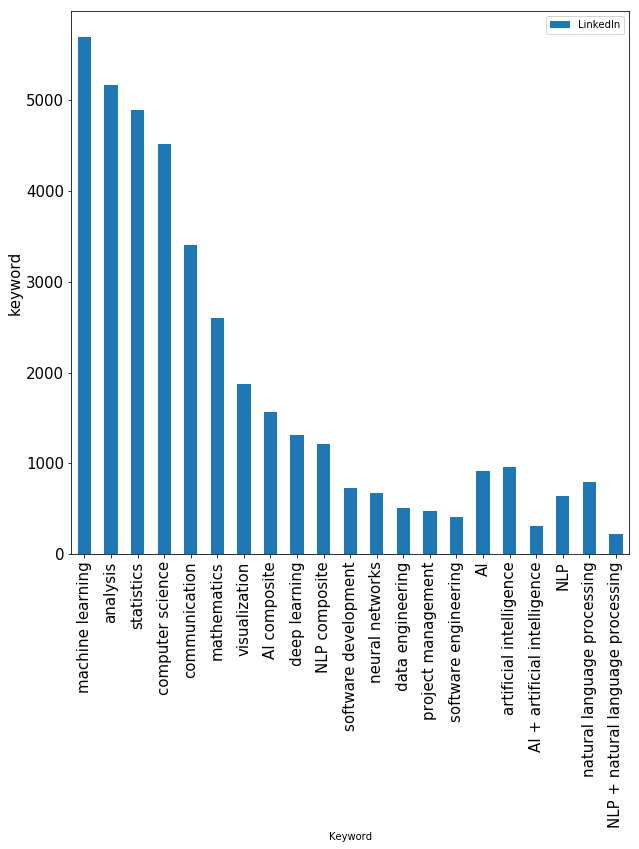

In [0]:
data.plot(x='Keyword',y='LinkedIn',kind='bar',figsize=(10,10),fontsize=15)
plt.ylabel('keyword frequency',fontsize=15)

# Indeed

In [0]:
data.Indeed = data.Indeed.apply(lambda x:x.split('.')[0]).replace('[^0-9]','',regex=True).apply(lambda x:int(x))

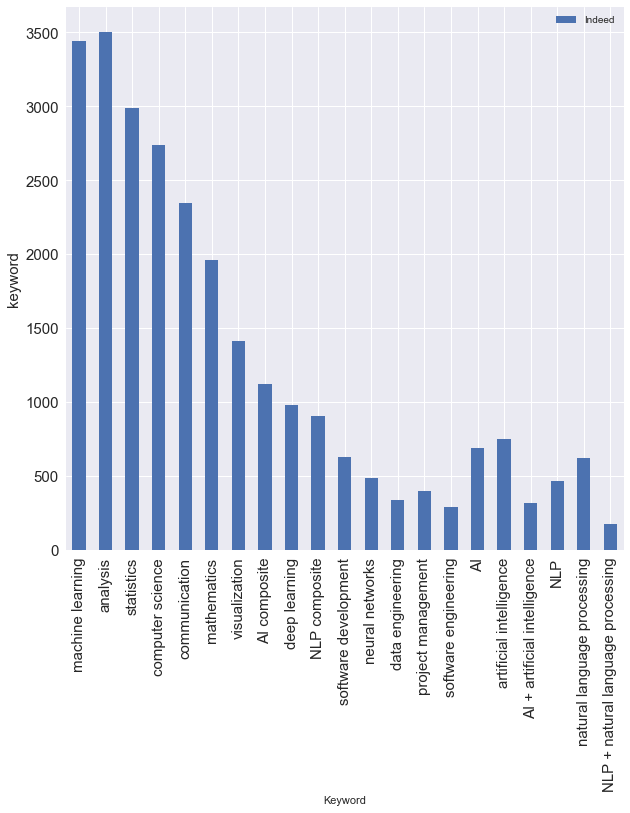

In [0]:
data.plot(x='Keyword',y='Indeed',kind='bar',figsize=(10,10),fontsize=15)
plt.ylabel('keyword',fontsize=15)

# SimplyHired

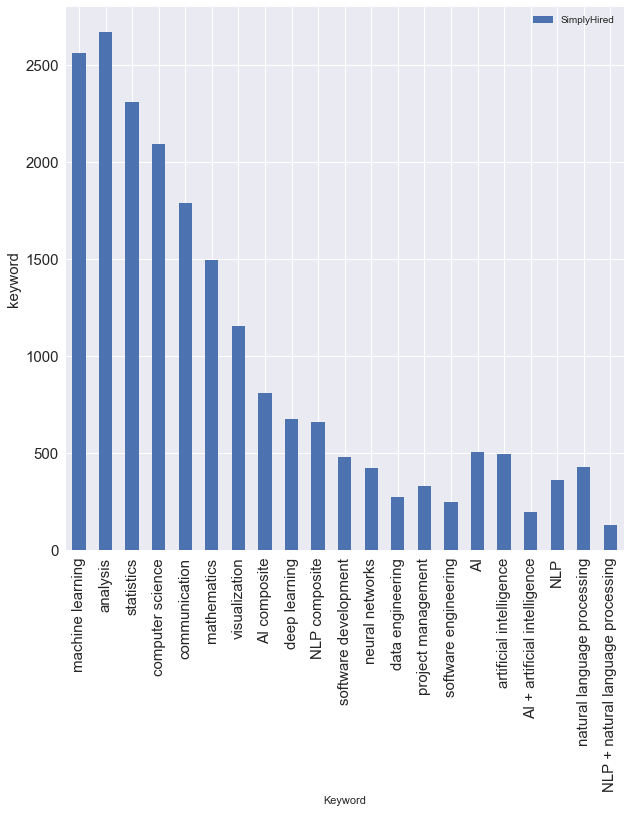

In [0]:
data.SimplyHired = data.SimplyHired.apply(lambda x:x.split('.')[0]).replace('[^0-9]','',regex=True).apply(lambda x:int(x))
data.plot(x='Keyword',y='SimplyHired',kind='bar',figsize=(10,10),fontsize=15)
plt.ylabel('keyword',fontsize=15)

# Monster

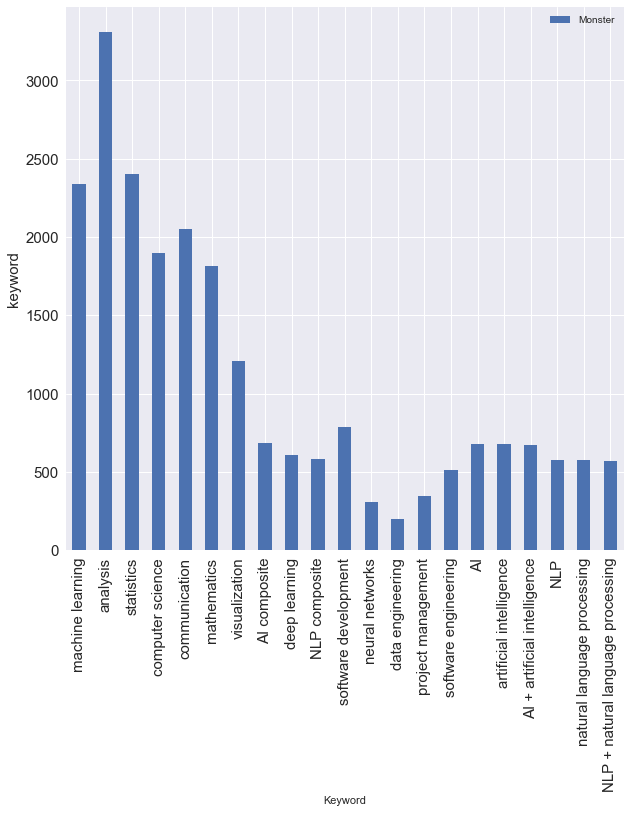

In [0]:
data.Monster = data.Monster.apply(lambda x:x.split('.')[0]).replace('[^0-9]','',regex=True).apply(lambda x:int(x))
data.plot(x='Keyword',y='Monster',kind='bar',figsize=(10,10),fontsize=15)
plt.ylabel('keyword frequency',fontsize=15)

# 1.2 Indeed web

In [0]:
URL_1 = 'https://www.indeed.ca/jobs?q=data+scientist&l=Canada&start'
HTML(URL_1)

In [0]:
def get_all_search_pages(URL_1):

    # get the HTML of the first search results page
    r = requests.get(URL_1)
    content = r.text

    # make a soup out of the first page of search results
    soup_1 = BeautifulSoup(content, 'html.parser')

    # extract the number of search results
    num_results_str = soup_1.find('div', {'id':'searchCount'}).text
    # parse the string and extract the total number (4th element), replace comma with an empty space, convert to int
    total_results = int(num_results_str.split()[3].replace(',', ''))

    # add the common part between all search pages
    
    next_pages_links = "https://www.indeed.ca" + soup_1.find('div', {'class': 'pagination'}).find('a').get('href')[:-2]

    print(next_pages_links)

    # create empty list to store URLs of all search results pages 
    List_of_all_URLs = []

    # add the first page to the 'List_of_all_URLs'
    List_of_all_URLs.append(next_pages_links)

    # add different starting positions for subsequent search results pages to 'List_of_all_URLs'
    for start_position in range(20,total_results,20):
        List_of_all_URLs.append(next_pages_links+str(start_position))
    
    return List_of_all_URLs, total_results

List_of_all_URLs, total_results = get_all_search_pages(URL_1)
print("\n{0} links with search results pages generated and saved to 'List_of_all_URLs'.".format(len(List_of_all_URLs)) +
      " Search returned a total of {0} results\n".format(total_results))
List_of_all_URLs

https://www.indeed.ca/jobs?q=data+scientist&l=Canada&start=

55 links with search results pages generated and saved to 'List_of_all_URLs'. Search returned a total of 1085 results



['https://www.indeed.ca/jobs?q=data+scientist&l=Canada&start=',
 'https://www.indeed.ca/jobs?q=data+scientist&l=Canada&start=20',
 'https://www.indeed.ca/jobs?q=data+scientist&l=Canada&start=40',
 'https://www.indeed.ca/jobs?q=data+scientist&l=Canada&start=60',
 'https://www.indeed.ca/jobs?q=data+scientist&l=Canada&start=80',
 'https://www.indeed.ca/jobs?q=data+scientist&l=Canada&start=100',
 'https://www.indeed.ca/jobs?q=data+scientist&l=Canada&start=120',
 'https://www.indeed.ca/jobs?q=data+scientist&l=Canada&start=140',
 'https://www.indeed.ca/jobs?q=data+scientist&l=Canada&start=160',
 'https://www.indeed.ca/jobs?q=data+scientist&l=Canada&start=180',
 'https://www.indeed.ca/jobs?q=data+scientist&l=Canada&start=200',
 'https://www.indeed.ca/jobs?q=data+scientist&l=Canada&start=220',
 'https://www.indeed.ca/jobs?q=data+scientist&l=Canada&start=240',
 'https://www.indeed.ca/jobs?q=data+scientist&l=Canada&start=260',
 'https://www.indeed.ca/jobs?q=data+scientist&l=Canada&start=280',
 '

In [0]:
scraping_results_dict = {} # this is a global dict used by 'scrape_job_info' to store scraping results to be parsed later

def scrape_job_info(job_search_results):

    global scraping_results_dict    # dict used to store results of scrapping
    
    # loop over all <div> tags supplied by the function 'scrape_job_links_and_info'
    for x in job_search_results:
        
        # extract the individual job posting link from a <div> tag
        job_link = "https://www.indeed.ca" + x.find('a')['href']
        
        # get the HTML code from the job posting page and save it as text to 'scrapping_results_dict'
        # link to the job posting is used as a key and HTML code of the job posting as a value
        job_html = requests.get(job_link)
        scraping_results_dict[job_link] = job_html.text
        
        # sleep for 0.5 second, to avoid too many requests to the indeed.ca server
        time.sleep(0.5)


def scrape_job_links_and_info(List_of_all_URLs):

    # loop over all pages in 'List_of_all_URLs' to extract links to each job posting
    for page_url in List_of_all_URLs:
        
        # get the HTML of the search results page
        page = requests.get(page_url)
        content = page.text
        # make a soup out of the HTML
        soup = BeautifulSoup(content, 'html.parser')
        
        # find all <div> tags containing each job posting links and feed them to the function 'scrape_job_info'
        results = soup.find_all('div',{'class': 'jobsearch-SerpJobCard row result'})
        scrape_job_info(results)

        results = soup.find_all('div',{'class': 'jobsearch-SerpJobCard row sjlast result'})
        scrape_job_info(results)

        results = soup.find_all('div',{'class': 'jobsearch-SerpJobCard lastRow row result'})
        scrape_job_info(results)
    
    print("Done!")

# run function 'scrape_job_links_and_info' to scrape every job posting from search results pages in 'List_of_all_URLs'
scrape_job_links_and_info(List_of_all_URLs)
print("{0} job postings have been scraped and saved to 'scraping_results_dict'.".format(len(scraping_results_dict)))

Done!
1065 job postings have been scraped and saved to 'scraping_results_dict'.


In [0]:
results_dict = {}   # empty dictionary to store results of parsing of job pages

# dictionary with skills used to parse job descriptions, categories become columns in 'results_df'
skills_keywords_dict = {
                            # tech skills
                            'Excel': ['Excel'],
                            'Python': ['Python'],
                            'R': ['R ', ' R ', 'R,', 'R/'], # 'R' surrounded by spaces and signs
                            'Ruby': ['Ruby'],
                            'Java/Scala': ['Java', 'JVM', 'Scala'],
                            'C/C++': ['C/C++', 'C++', ' C '],   # 'C' surrounded by spaces and signs
                            'MATLAB': ['MATLAB'],
                            'SAS': ['SAS'],
                            'SQL/databases': ['SQL', 'databases'],
                            'SPSS': ['SPSS'],
                            'Stata': ['Stata'],
                            'RapidMiner': ['RapidMiner', 'Rapid Miner'],
                            'Machine Learning': ['Machine Learning', 'ML'],
                            'Data Mining/Analytics': ['Data Mining', 'DM', 'Analytics'],
                            'NLP': ['Natural Language Processing', 'NLP'],
                            'Visualisation': ['visualisation', 'visualization','vision','visualizations','visual'],
                            'Big Data': ['Big Data', 'Spark', 'kafka', 'Hive', 
                                         'beam', 'Hadoop', 'MapReduce', 'Hbase'],
                            'Cloud': ['Cloud', 'AWS', 'GCP', 'Azure ', 'Google Cloud'],
                            'REST': ['REST', 'flask', 'Sinatra'],
                            'Math': ['Algebra', 'Statistics', 'Operations research'],
                            'DevOps': ['DevOps', 'TDD', 'test-driven', 'GitHub'],
                            # soft skills
                            'communication': ['communication', 'presentation'],
                            'problem solving': ['problem solving'],
                            'project_management': ['project management'],
                            'leadership': ['leadership'],
                            'consulting': ['consulting']
                        }


def parse_job_info(scraping_results_dict, skills_keywords_dict):

    global resutls_dict    # global dict used to store results of scraping
    
    # loop over all key(link)-value(HTML code) pairs in scraping results
    for link, job_html_text in scraping_results_dict.items():
        
        # make a soup out of a job posting HTML code
        soup_job = BeautifulSoup(job_html_text, 'html.parser')
        
        results_dict[link] = {} # new sub-dictionary (value) in the 'results_dict' under (key) 'link' 
        
        # extract job title from the job page
        try:
            results_dict[link]['job_title'] = soup_job.find_all('h3', 
                                {'class':"icl-u-xs-mb--xs icl-u-xs-mt--none jobsearch-JobInfoHeader-title"})[0].text   
        except IndexError:
            results_dict[link]['job_title'] = 'Not found'
        # extract company name
        try:
            results_dict[link]['company_name'] = soup_job.find_all('div', 
                                                                   {'class': 'icl-u-lg-mr--sm icl-u-xs-mr--xs'})[0].text 
        except IndexError:
            results_dict[link]['company_name'] = 'Not found'
        # extract job location
        try:
            # get the part of the <div> tag containing location ("MindGeek 47 reviews-Montréal, QC" on top of a job posting page)
            location_line = soup_job.find_all('div', 
              {'class':"jobsearch-InlineCompanyRating icl-u-xs-mt--xs jobsearch-DesktopStickyContainer-companyrating"})[0]
            # convert the tag to string, split by '-', select the second element (contains job location)
            results_dict[link]['job_location'] = location_line.text.split('-')[1]
        except IndexError:
            results_dict[link]['job_location'] = 'Not found'
        # extract job description section
        try:
            results_dict[link]['job_description'] = soup_job.find_all('div', 
                                            {'class': 'jobsearch-JobComponent-description icl-u-xs-mt--md'})[0].text
        except IndexError:
            results_dict[link]['job_description'] = 'Not found'
        # extract date posted
        try:
            results_dict[link]['date'] = soup_job.find_all('div', 
                                                        {'class':'jobsearch-JobMetadataFooter'})[0].text.split(' - ')[1]
        except IndexError:
            results_dict[link]['date'] = 'Not found'
                
        # search for the skills
        soup_job_text = soup_job.text
        for skill_category, skills in skills_keywords_dict.items(): # loop over all keys and sublists in 'skills_keywords_dict'
            
            category_found = 0   # variable used to store results of the intermediate check (loop below)
            
            for skill in skills:        # loop over all skills in the sublist of 'skills_keywords_dict'
                if soup_job_text.find(skill) != -1:     # if skill from the sublist is found, set 'category_found' to 1
                    category_found = 1
            
            results_dict[link][skill_category] = category_found   # skill set to 1 if found, 0 if not, in 'resutls_dict'
        
# feed all job page HTMLs (values in 'scraping_results_dict') to function 'parse_job_info'
parse_job_info(scraping_results_dict, skills_keywords_dict)
results_df = pd.DataFrame(results_dict).T.reset_index()

In [0]:
# get the list of all columns in 'results_df'
cols_for_duplicate_check = results_df.columns
# remove column 'index' (contains job posting link) from the match criteria used by the duplicate check
remove_col = ['index', 'date']
cols_for_duplicate_check = cols_for_duplicate_check.drop(remove_col)

# get a boolean series that marks all rows that have duplicates (including first instances) as True
mask = results_df.duplicated(keep=False, subset=cols_for_duplicate_check)
# use the boolean mask to subset the DataFrame, sort results by 'job_title' and 'company_name'
results_df[mask].sort_values(by=['job_title', 'company_name'])

,index,Big Data,C/C++,Cloud,Data Mining/Analytics,DevOps,Excel,Java/Scala,MATLAB,Machine Learning,...,communication,company_name,consulting,date,job_description,job_location,job_title,leadership,problem solving,project_management
335,https://www.indeed.ca/pagead/clk?mo=r&ad=-6NYl...,1,0,1,0,0,0,0,0,1,...,1,Prodigy Game,0,5 days ago,"In the last 6 years, Prodigy has gone from 3,0...","Burlington, ON",Big Data Engineer,0,0,1
336,https://www.indeed.ca/pagead/clk?mo=r&ad=-6NYl...,1,0,1,0,0,0,0,0,1,...,1,Prodigy Game,0,5 days ago,"In the last 6 years, Prodigy has gone from 3,0...","Burlington, ON",Big Data Engineer,0,0,1
337,https://www.indeed.ca/pagead/clk?mo=r&ad=-6NYl...,1,0,1,0,0,0,0,0,1,...,1,Prodigy Game,0,5 days ago,"Burlington, ONIn the last 6 years, Prodigy has...","Burlington, ON",Big Data Engineer,0,0,1
338,https://www.indeed.ca/pagead/clk?mo=r&ad=-6NYl...,1,0,1,0,0,0,0,0,1,...,1,Prodigy Game,0,5 days ago,"In the last 6 years, Prodigy has gone from 3,0...","Burlington, ON",Big Data Engineer,0,0,1
339,https://www.indeed.ca/pagead/clk?mo=r&ad=-6NYl...,1,0,1,0,0,0,0,0,1,...,1,Prodigy Game,0,5 days ago,"In the last 6 years, Prodigy has gone from 3,0...","Burlington, ON",Big Data Engineer,0,0,1
340,https://www.indeed.ca/pagead/clk?mo=r&ad=-6NYl...,1,0,1,0,0,0,0,0,1,...,1,Prodigy Game,0,5 days ago,"In the last 6 years, Prodigy has gone from 3,0...","Burlington, ON",Big Data Engineer,0,0,1
341,https://www.indeed.ca/pagead/clk?mo=r&ad=-6NYl...,1,0,1,0,0,0,0,0,1,...,1,Prodigy Game,0,5 days ago,"In the last 6 years, Prodigy has gone from 3,0...","Burlington, ON",Big Data Engineer,0,0,1
342,https://www.indeed.ca/pagead/clk?mo=r&ad=-6NYl...,1,0,1,0,0,0,0,0,1,...,1,Prodigy Game,0,5 days ago,"In the last 6 years, Prodigy has gone from 3,0...","Burlington, ON",Big Data Engineer,0,0,1
343,https://www.indeed.ca/pagead/clk?mo=r&ad=-6NYl...,1,0,1,0,0,0,0,0,1,...,1,Prodigy Game,0,5 days ago,"Burlington, ONIn the last 6 years, Prodigy has...","Burlington, ON",Big Data Engineer,0,0,1
910,https://www.indeed.ca/rc/clk?jk=c7a9706e3e1c71...,1,0,1,0,0,0,0,0,1,...,1,Prodigy Game,0,5 days ago,"Burlington, ONIn the last 6 years, Prodigy has...","Burlington, ON",Big Data Engineer,0,0,1


In [0]:
# original number of records in 'results_df'
old_num_records = len(results_df)
# remove duplicate rows from 'results_df' using the same match criteria as above ('index' excluded)
results_df = results_df.drop_duplicates(subset=cols_for_duplicate_check)
# number of records after duplicate rows are removed (first instances are saved)
new_num_records = len(results_df)
print("Duplicate check using as match criteria all columns, with {0} excluded, found {1} results."
     .format(remove_col,
            old_num_records - new_num_records))
print("{0} duplicated rows have been removed from the DataFrame 'results_df'.".format(old_num_records - new_num_records))
print("\n{0} unque records remain in the data frame 'results_df'".format(new_num_records))

Duplicate check using as match criteria all columns, with ['index', 'date'] excluded, found 268 results.
268 duplicated rows have been removed from the DataFrame 'results_df'.

797 unque records remain in the data frame 'results_df'


In [0]:
# reordering columns
cols = results_df.columns 
new_cols = cols.drop(['company_name', 'job_location', 'job_description', 'job_title', 'index', 'date'])
new_cols = new_cols.insert(0, 'job_title')
new_cols = new_cols.insert(1, 'company_name')
new_cols = new_cols.insert(2, 'job_location')
new_cols = new_cols.insert(3, 'date')
new_cols = new_cols.insert(4, 'job_description')
results_df = results_df[new_cols]
results_df.head()

,job_title,company_name,job_location,date,job_description,Big Data,C/C++,Cloud,Data Mining/Analytics,DevOps,...,SAS,SPSS,SQL/databases,Stata,Visualisation,communication,consulting,leadership,problem solving,project_management
0,Computational Chemist,Xenon Pharmaceuticals Inc.,"Burnaby, BC",save job,We are a clinical stage biopharmaceutical comp...,0,0,0,0,0,...,0,0,1,0,1,1,0,0,1,0
1,Microbiologist,Lallemand Inc. / BioForest,"Sault Ste. Marie, ON",save job,"Sault Ste. Marie, ONPermanent$62,000 - $75,000...",0,0,0,0,0,...,0,0,1,0,1,1,0,0,0,0
2,"Research Scientist, In Vitro Biology",Xenon Pharmaceuticals Inc.,"Burnaby, BC",save job,"Burnaby, BCWe are a clinical stage biopharmace...",0,0,0,0,0,...,0,0,1,0,1,1,0,1,1,0
3,Laboratory Coordinator,AGAT Laboratories,"Edmonton, AB",save job,"Edmonton, ABContractAGAT Laboratories is a ful...",0,0,0,1,0,...,0,0,1,0,1,0,0,0,0,0
4,Laboratory Technician - Grande Prairie,AGAT Laboratories,"Grande Prairie, AB",save job,ContractAGAT Laboratories is a full-service la...,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


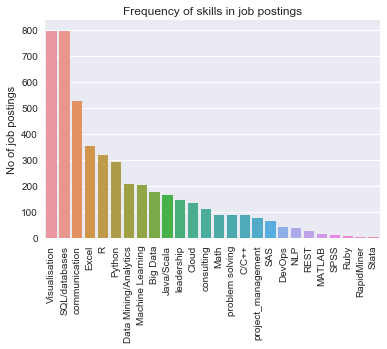

In [0]:
sums_of_skills = results_df.iloc[:, 5:].sum().sort_values(ascending=False)
sns.barplot(x=sums_of_skills.index, y=sums_of_skills)
plt.xticks(rotation=90)
plt.ylabel("No of job postings")
plt.title("Frequency of skills in job postings")
plt.show()

# 1.3 Course_info: Dataquest,  Cousera and Datacamp

In [0]:
skills_keywords = {
                            # tech skills
                            'Programming Language':['software','r ', ' r ', 'r,', 'r/','c/c++', 'c++', ' c ',
                                                    'matlab','java', 'jvm', 'scala','programming',
                                                   'pandas','numpy','language'],
                            'Algorithm':['algorithm','alg','linear','logistic','cluster','clustering','algebra',
                                         'k nearest neighbors','knn','decision trees'],
                            # 'Python': ['python'],
                            # 'R': ['R ', ' R ', 'R,', 'R/'], # 'R' surrounded by spaces and signs
                            # 'Java/Scala': ['java', 'jvm', 'scala'],
                            # 'C/C++': ['c/c++', 'c++', ' c '],   # 'C' surrounded by spaces and signs
                            # 'MATLAB': ['matlab'],
                            'deep learning':['deep','deeply'],
                            'Feature engineering' :['feature','features'],
                            'SQL/databases': ['sql', 'databases'],
                            'statistics': ['statistics'],
                            'Neural Network': ['neural'],
                            'Machine Learning': ['machine learning', 'ml'],
                            'Data Mining/Analytics': ['data mining', 'dm', 'analytics'],
                            'natural language': ['natural language', 'nlp'],
                            'Visualisation': ['visualisation', 'visualization','vision','visualizations','visualize','image'],
                            'Big Data': ['big data', 'spark', 'kafka', 'hive', 
                                         'beam', 'hadoop', 'mapReduce', 'hbase','data','dataframes','database','databases'],
                            'Cloud': ['cloud', 'aws', 'gcp', 'azure ', 'google cloud','hadoop'],
                            'Data analysis': ['analysis','analyses','analyze'],
                            'Model implementation':['model','models'],
                            'Math': ['algebra', 'statistics', 'operations research','numerical'],
                            'Web': ['web'],
                            'AI': ['artificial intelligence','artificial','ai','intelligence'],
                            # soft skills
                            'communication': ['communication', 'presentation','commmunicating']
                        }

In [0]:
def data_cleaning(job_df):
    """
    (DataFrame) -> list of strings
    Takes in DataFrame of the job posting, produce a list of job summaries as list of strings
    """
    summary_list = job_df['description'].tolist()
    
    with open('stop_words.txt',"r") as file2:
        stop_words=file2.readlines()
    stop_words = [e.strip("\n") for e in stop_words]
    
    file_list = summary_list
    
    for i in range(len(file_list)):
        # remove html tags
        cleanr = re.compile('<.*?>')
        file_list[i] = re.sub(cleanr, '', file_list[i]) 
        
        #replace html character codes
        #parser = HTMLParser()
        #html_decoded_string = parser.unescape(file_list[i])
        #file_list[i] = html_decoded_string
        
        #remove urls
        file_list[i] = re.sub(r'http\S+', '', file_list[i])
        
        
        #lowercase characters
        file_list[i] = file_list[i].lower()
        
        #remove punctuation
        tokenizer = RegexpTokenizer(r'\w+')
        file_list[i] = tokenizer.tokenize(file_list[i])
        
        #remove stopwords
        #cleaned_text = list(filter(lambda x: x not in stop_words, file_list[i]))
        #file_list[i] = cleaned_text
        file_list[i] = " ".join(file_list[i])
    return file_list

In [0]:
datacamp = pd.read_csv('df_courses_datacamp.csv')
datacamp.head()

,title,description
0,introduction to python,master the basics of data analysis in python. ...
1,intermediate python for data science,level up your data science skills by creating ...
2,python data science toolbox (part 1),learn the art of writing your own functions in...
3,python data science toolbox (part 2),continue to build your modern data science ski...
4,importing data in python (part 1),learn to import data into python from various ...


In [0]:
dataquest = pd.read_csv('dataquest.csv')
dataquest = dataquest.drop([0,1,2,3],axis = 0)
dataquest.head()

,title,description
4,Python for Data Science: Fundamentals,Choose the courses that meet your specific nee...
5,Python for Data Science: Intermediate,Learn the basics of Python programming and dat...
6,Pandas & NumPy Fundamentals,Learn how to analyze data using the pandas and...
7,Exploratory Data Visualization,Learn how to explore data by creating and inte...
8,Storytelling Through Data Visualization,Learn how to communicate insights and tell sto...


In [0]:
coursera = pd.read_csv('coursera.csv')
coursera.head()

,title,description
0,Python for Data Science,This introduction to Python will kickstart you...
1,Applied Data Science with Python Specialization,The 5 courses in this University of Michigan s...
2,SQL for Data Science,As data collection has increased exponentially...
3,Introduction to Data Science in Python,This course will introduce the learner to the ...
4,Data Science Specialization,"Ask the right questions, manipulate data sets,..."


In [0]:
course_data = datacamp.append(dataquest)
course_data = course_data.append(coursera)
# course_data = pd.concat([datacamp,dataquest,coursera],axis=1)
course_data = course_data.reset_index(drop=True)
course_data.tail()

,title,description
331,Introduction to Data Exploration and Visualiza...,"This course answers the questions, What is dat..."
332,Design and Build a Data Warehouse for Business...,"The capstone course, Design and Build a Data W..."
333,Principles of fMRI 2,This course covers the analysis of Functional ...
334,Web of Data,This MOOC â a joint initiative between EIT D...
335,Introduction to Formal Concept Analysis,This course is an introduction into formal con...


In [0]:
for i in range(len(course_data)):
    course_data.description[i] = str(course_data.description[i]).lower()

In [0]:
course_desc = data_cleaning(course_data)
course_desc

['master the basics of data analysis in python expand your skill set by learning scientific computing with numpy',
 'level up your data science skills by creating visualizations using matplotlib and manipulating data frames with pandas',
 'learn the art of writing your own functions in python as well as key concepts like scoping and error handling',
 'continue to build your modern data science skills by learning about iterators and list comprehensions',
 'learn to import data into python from various sources such as excel sql sas and right from the web',
 'improve your python data importing skills and learn to work with web and api data',
 'this course will equip you with all the skills you need to clean your data in python',
 'learn how to use the industry standard pandas library to import build and manipulate dataframes',
 'you will learn how to tidy rearrange and restructure your data using versatile pandas dataframes',
 'this course is all about the act of combining or merging data

In [0]:
# res = []
results_dict = {}

for name in skills_keywords:
    results_dict[name] = 0
    
def skills(text, skills_keywords):
    global results_dict
    for i in range(len(text)): 
        for skill_category, skills in skills_keywords.items(): # loop over all keys and sublists in 'skills_keywords_dict'
            category_found = 0
            for skill in skills:
                if text.description[i].find(skill) != -1:     # if skill from the sublist is found, set 'category_found' to 1
                    category_found = 1
                    results_dict[skill_category] += category_found
#         print(results_dict)        
#         res.append(results_dict)

In [0]:
skills(course_data,skills_keywords)
results_dict

NameError: name 'course_data' is not defined

In [0]:
results_dict['AI']

131

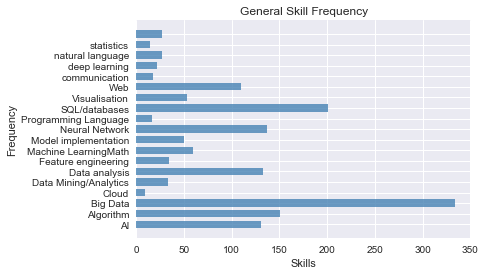

In [0]:
name_list = ['AI','Algorithm','Big Data','Cloud','Data Mining/Analytics','Data analysis','Feature engineering','Machine Learning'
            'Math','Model implementation','Neural Network','Programming Language','SQL/databases','Visualisation',
            'Web','communication','deep learning','natural language','statistics']

num_list = [131,151,334,9,33,133,34,59,50,137,17,201,53,110,18,22,27,14,27]


plt.barh(range(19), num_list, height=0.7, color='steelblue', alpha=0.8) 
plt.yticks(range(19), ['AI','Algorithm','Big Data','Cloud','Data Mining/Analytics','Data analysis','Feature engineering','Machine Learning'
            'Math','Model implementation','Neural Network','Programming Language','SQL/databases','Visualisation',
            'Web','communication','deep learning','natural language','statistics'])
plt.title('General Skill Frequency')
plt.xlabel('Skills')
plt.ylabel('Frequency')
plt.show()

# 1.4 US_jobs

In [0]:
skills_keywords = {
                            
                            'Python': ['python','pandas','numpy','pytorch','tensorflow','sk-learn'],
                            'R': ['r ', ' r ', 'r,', 'r/'], # 'R' surrounded by spaces and signs
                            'Java/Scala': ['java', 'jvm', 'scala'],
                            'C/C++': ['c/c++', 'c++', ' c '],   # 'C' surrounded by spaces and signs
                            'MATLAB': ['matlab'],
                            'Deep learning':['deep','deeply'],
                            'Feature engineering' :['feature','features'],
                            'SQL/databases': ['sql', 'databases','database'],
                            'Neural Network': ['neural'],
                            'Machine Learning': ['machine learning', 'ml'],
                            'Data Mining/Analytics': ['data mining', 'dm', 'mining','mine'],
                            'Natural language': ['natural language', 'nlp','natural'],
                            'Visualisation': ['visualisation', 'visualization','vision','visualizations','visualize','image'],
                            'Big Data': ['big data', 'spark', 'kafka', 'hive', 
                                         'beam', 'hadoop', 'mapReduce', 'hbase','dataframes','database','databases'],
                            'Cloud': ['cloud', 'aws', 'gcp', 'azure ', 'google cloud','hadoop'],
                            'Data analysis': ['analysis','analyses','analyze','analyst','analyzing','analytics','analytical'],
                            'Model implementation':['model','models','optimization'],
                            'Math': ['algebra', 'statistics', 'operations research','numerical','math','mathematics'],
                            'Statistics':['statisstical','stasistics'],
                            'Web': ['web','scrap','scrapping'],
                            'AI': ['artificial intelligence','artificial','ai','intelligence'],
                            # soft skills
                            'communication': ['communication', 'presentation','commmunicating'],
                            'Excel':['excel'],
                            'Business Analysis':['business','commerical'],
                            'Data forecast':['forcast','forcasting','unknown'],
                            'agile':['agile']
                        }

In [0]:
def data_cleaning(job_df):
    """
    (DataFrame) -> list of strings
    Takes in DataFrame of the job posting, produce a list of job summaries as list of strings
    """
    summary_list = job_df['description'].tolist()
    
    with open('stop_words.txt',"r") as file2:
        stop_words=file2.readlines()
    stop_words = [e.strip("\n") for e in stop_words]
    
    file_list = summary_list
    
    for i in range(len(file_list)):
        # remove html tags
        cleanr = re.compile('<.*?>')
        file_list[i] = re.sub(cleanr, '', file_list[i]) 
        
        #replace html character codes
        #parser = HTMLParser()
        #html_decoded_string = parser.unescape(file_list[i])
        #file_list[i] = html_decoded_string
        
        #remove urls
        file_list[i] = re.sub(r'http\S+', '', file_list[i])
        
        
        #lowercase characters
        file_list[i] = file_list[i].lower()
        
        #remove punctuation
        tokenizer = RegexpTokenizer(r'\w+')
        file_list[i] = tokenizer.tokenize(file_list[i])
        
        #remove stopwords
        #cleaned_text = list(filter(lambda x: x not in stop_words, file_list[i]))
        #file_list[i] = cleaned_text
        file_list[i] = " ".join(file_list[i])
    return file_list

In [0]:
us_job = pd.read_csv('alldata.csv')
for i in range(len(us_job)):
    us_job.description[i] = str(us_job.description[i]).lower()

C:\Users\Kimi\Anaconda3\envs\tensoeflow\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
us_job.head()

,position,company,description,reviews,location
0,Development Director,ALS TDI,development director\nals therapy development ...,NaN,"Atlanta, GA 30301"
1,An Ostentatiously-Excitable Principal Research...,The Hexagon Lavish,"job description\n\n""the road that leads to acc...",NaN,"Atlanta, GA"
2,Data Scientist,Xpert Staffing,"growing company located in the atlanta, ga are...",NaN,"Atlanta, GA"
3,Data Analyst,Operation HOPE,department: program operationsposition locatio...,44.0,"Atlanta, GA 30303"
4,Assistant Professor -TT - Signal Processing & ...,Emory University,description\nthe emory university department o...,550.0,"Atlanta, GA"


In [0]:
us_job_desc = data_cleaning(us_job)

US_JOB = pd.DataFrame({
    'description': us_job_desc},
    columns=['description']
    )

us_job = us_job.drop(['description','company','reviews','location'],axis = 1)

all_job= pd.concat([us_job,US_JOB],axis = 1)
all_job.head()

,position,description
0,Development Director,development director als therapy development i...
1,An Ostentatiously-Excitable Principal Research...,job description the road that leads to accompl...
2,Data Scientist,growing company located in the atlanta ga area...
3,Data Analyst,department program operationsposition location...
4,Assistant Professor -TT - Signal Processing & ...,description the emory university department of...


In [0]:
us_job.head()

,position
0,Development Director
1,An Ostentatiously-Excitable Principal Research...
2,Data Scientist
3,Data Analyst
4,Assistant Professor -TT - Signal Processing & ...


# ML

In [0]:
all_job.loc[:,:] = all_job.loc[:,:].fillna('unknown')
ml_pos = all_job.loc[all_job['position'].str.contains('Machine Learning')]
ml_pos2 = all_job.loc[all_job['position'].str.contains('AI')]
ml_pos = ml_pos.append(ml_pos2)
ml_pos2 = all_job.loc[all_job['position'].str.contains('Intelligence')]
ml_pos = ml_pos.append(ml_pos2)
ml_pos2 = all_job.loc[all_job['position'].str.contains('Train')]
ml_pos = ml_pos.append(ml_pos2)
ml_pos.index = range(len(ml_pos.index))
ml_pos.shape[0]

723

In [0]:
def ML_skill(text, skills_keywords):
    global results_dict
    for i in range(len(text)): 
        for skill_category, skills in skills_keywords.items(): # loop over all keys and sublists in 'skills_keywords_dict'
            category_found = 0
            for skill in skills:
                if text.description[i].find(skill) != -1:     # if skill from the sublist is found, set 'category_found' to 1
                    ML.loc[i,str(skill_category)] = 1
skill_onhot  = np.zeros(shape=(ml_pos.shape[0],len(skills_keywords)))
skill_onhot.shape

ML = pd.DataFrame(skill_onhot,columns=skills_keywords)
ML_skill(ml_pos,skills_keywords)
ML.head()

,Python,R,Java/Scala,C/C++,MATLAB,Deep learning,Feature engineering,SQL/databases,Neural Network,Machine Learning,...,Model implementation,Math,Statistics,Web,AI,communication,Excel,Business Analysis,Data forecast,agile
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
3,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [0]:
ML['Field'] = 'Machine Learning'
ML.head()

,Python,R,Java/Scala,C/C++,MATLAB,Deep learning,Feature engineering,SQL/databases,Neural Network,Machine Learning,...,Math,Statistics,Web,AI,communication,Excel,Business Analysis,Data forecast,agile,Field
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Machine Learning
1,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,Machine Learning
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,Machine Learning
3,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,Machine Learning
4,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,Machine Learning


# Data science

In [0]:
ds_pos = all_job.loc[all_job['position'].str.contains('Data Scientist')]
ds_pos2 = all_job.loc[all_job['position'].str.contains('Science')]
ds_pos = ds_pos.append(ds_pos2)
ds_pos.index = range(len(ds_pos.index))
ds_pos.shape[0]

1517

In [0]:
def DS_skill(text, skills_keywords):
    global results_dict
    for i in range(len(text)): 
        for skill_category, skills in skills_keywords.items(): # loop over all keys and sublists in 'skills_keywords_dict'
            category_found = 0
            for skill in skills:
                if text.description[i].find(skill) != -1:     # if skill from the sublist is found, set 'category_found' to 1
                    DS.loc[i,str(skill_category)] = 1
skill_onhot  = np.zeros(shape=(ds_pos.shape[0],len(skills_keywords)))
skill_onhot.shape

DS = pd.DataFrame(skill_onhot,columns=skills_keywords)
DS_skill(ds_pos,skills_keywords)
DS.head()

,Python,R,Java/Scala,C/C++,MATLAB,Deep learning,Feature engineering,SQL/databases,Neural Network,Machine Learning,...,Model implementation,Math,Statistics,Web,AI,communication,Excel,Business Analysis,Data forecast,agile
0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
3,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0


In [0]:
DS['Field'] = 'Data Science'
DS.head()

,Python,R,Java/Scala,C/C++,MATLAB,Deep learning,Feature engineering,SQL/databases,Neural Network,Machine Learning,...,Math,Statistics,Web,AI,communication,Excel,Business Analysis,Data forecast,agile,Field
0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,Data Science
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,Data Science
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,Data Science
3,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,Data Science
4,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,Data Science


# Analyst

In [0]:
ana_pos = all_job.loc[all_job['position'].str.contains('Analyst')]
ana_pos2 = all_job.loc[all_job['position'].str.contains('Analysis')]
ana_pos = ana_pos.append(ana_pos2)
ana_pos2 = all_job.loc[all_job['position'].str.contains('Analytics')]
ana_pos = ana_pos.append(ana_pos2)

ana_pos.index = range(len(ana_pos.index))
ana_pos.shape[0]

1161

In [0]:
def ANA_skill(text, skills_keywords):
    global results_dict
    for i in range(len(text)): 
        for skill_category, skills in skills_keywords.items(): # loop over all keys and sublists in 'skills_keywords_dict'
            category_found = 0
            for skill in skills:
                if text.description[i].find(skill) != -1:     # if skill from the sublist is found, set 'category_found' to 1
                    ANA.loc[i,str(skill_category)] = 1
skill_onhot  = np.zeros(shape=(ana_pos.shape[0],len(skills_keywords)))
skill_onhot.shape

ANA = pd.DataFrame(skill_onhot,columns=skills_keywords)
ANA_skill(ana_pos,skills_keywords)
ANA.head()

,Python,R,Java/Scala,C/C++,MATLAB,Deep learning,Feature engineering,SQL/databases,Neural Network,Machine Learning,...,Model implementation,Math,Statistics,Web,AI,communication,Excel,Business Analysis,Data forecast,agile
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
4,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [0]:
ANA['Field'] = 'Data analysis'
ANA.head()

,Python,R,Java/Scala,C/C++,MATLAB,Deep learning,Feature engineering,SQL/databases,Neural Network,Machine Learning,...,Math,Statistics,Web,AI,communication,Excel,Business Analysis,Data forecast,agile,Field
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Data analysis
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,Data analysis
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,Data analysis
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,Data analysis
4,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Data analysis


# Programming

In [0]:
program_pos = all_job.loc[all_job['position'].str.contains('Programmer')]
program_pos2 = all_job.loc[all_job['position'].str.contains('Program')]
program_pos = program_pos.append(program_pos2)
program_pos2 = all_job.loc[all_job['position'].str.contains('Programming')]
program_pos = program_pos.append(program_pos2)
program_pos2 = all_job.loc[all_job['position'].str.contains('Python')]
program_pos = program_pos.append(program_pos2)
program_pos2 = all_job.loc[all_job['position'].str.contains('Software')]
program_pos = program_pos.append(program_pos2)
program_pos2 = all_job.loc[all_job['position'].str.contains('App')]
program_pos = program_pos.append(program_pos2)

program_pos.index = range(len(program_pos.index))
program_pos.shape[0]

943

In [0]:
def PRO_skill(text, skills_keywords):
    global results_dict
    for i in range(len(text)): 
        for skill_category, skills in skills_keywords.items(): # loop over all keys and sublists in 'skills_keywords_dict'
            category_found = 0
            for skill in skills:
                if text.description[i].find(skill) != -1:     # if skill from the sublist is found, set 'category_found' to 1
                    PRO.loc[i,str(skill_category)] = 1
skill_onhot  = np.zeros(shape=(program_pos.shape[0],len(skills_keywords)))
skill_onhot.shape

PRO = pd.DataFrame(skill_onhot,columns=skills_keywords)
PRO_skill(program_pos,skills_keywords)
PRO.head()

,Python,R,Java/Scala,C/C++,MATLAB,Deep learning,Feature engineering,SQL/databases,Neural Network,Machine Learning,...,Model implementation,Math,Statistics,Web,AI,communication,Excel,Business Analysis,Data forecast,agile
0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [0]:
PRO['Field'] = 'Programming'
PRO.head()

,Python,R,Java/Scala,C/C++,MATLAB,Deep learning,Feature engineering,SQL/databases,Neural Network,Machine Learning,...,Math,Statistics,Web,AI,communication,Excel,Business Analysis,Data forecast,agile,Field
0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,Programming
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,Programming
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,Programming
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,Programming
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,Programming


# math

In [0]:
math_pos = all_job.loc[all_job['position'].str.contains('Math')]
math_pos2 = all_job.loc[all_job['position'].str.contains('Statistical')]
math_pos = math_pos.append(program_pos2)
math_pos2 = all_job.loc[all_job['position'].str.contains('Statistic')]
math_pos = math_pos.append(program_pos2)
math_pos.index = range(len(math_pos.index))
math_pos.shape[0]

317

In [0]:
def MA_skill(text, skills_keywords):
    global results_dict
    for i in range(len(text)): 
        for skill_category, skills in skills_keywords.items(): # loop over all keys and sublists in 'skills_keywords_dict'
            category_found = 0
            for skill in skills:
                if text.description[i].find(skill) != -1:     # if skill from the sublist is found, set 'category_found' to 1
                    MA.loc[i,str(skill_category)] = 1
skill_onhot  = np.zeros(shape=(math_pos .shape[0],len(skills_keywords)))
skill_onhot.shape

MA = pd.DataFrame(skill_onhot,columns=skills_keywords)
MA_skill(math_pos ,skills_keywords)
MA.head()

,Python,R,Java/Scala,C/C++,MATLAB,Deep learning,Feature engineering,SQL/databases,Neural Network,Machine Learning,...,Model implementation,Math,Statistics,Web,AI,communication,Excel,Business Analysis,Data forecast,agile
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
3,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
4,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


In [0]:
MA['Field'] = 'math'
MA.head()

,Python,R,Java/Scala,C/C++,MATLAB,Deep learning,Feature engineering,SQL/databases,Neural Network,Machine Learning,...,Math,Statistics,Web,AI,communication,Excel,Business Analysis,Data forecast,agile,Field
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,math
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,math
2,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,math
3,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,math
4,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,math


# visual/data mining

In [0]:
visual_pos = {}
visual_pos = all_job.loc[all_job['position'].str.contains('Model')]
visual_pos2 = all_job.loc[all_job['position'].str.contains('Statistical')]
visual_pos = visual_pos.append(visual_pos2)
visual_pos2 = all_job.loc[all_job['position'].str.contains('Implementation')]
visual_pos = visual_pos.append(visual_pos2)
visual_pos2 = all_job.loc[all_job['position'].str.contains('Optimization')]
visual_pos = visual_pos.append(visual_pos2)
visual_pos2 = all_job.loc[all_job['position'].str.contains('Visual')]
visual_pos = visual_pos.append(visual_pos2)
visual_pos2 = all_job.loc[all_job['position'].str.contains('Visualization')]
visual_pos = visual_pos.append(visual_pos2)
visual_pos2 = all_job.loc[all_job['position'].str.contains('Scraping')]
visual_pos = visual_pos.append(visual_pos2)
visual_pos2 = all_job.loc[all_job['position'].str.contains('Exploration')]
visual_pos = visual_pos.append(visual_pos2)
visual_pos2 = all_job.loc[all_job['position'].str.contains('Mining')]
visual_pos = visual_pos.append(visual_pos2)
visual_pos.index = range(len(visual_pos.index))
visual_pos.shape[0]

227

In [0]:
def VS_skill(text, skills_keywords):
    global results_dict
    for i in range(len(text)): 
        for skill_category, skills in skills_keywords.items(): # loop over all keys and sublists in 'skills_keywords_dict'
            category_found = 0
            for skill in skills:
                if text.description[i].find(skill) != -1:     # if skill from the sublist is found, set 'category_found' to 1
                    VS.loc[i,str(skill_category)] = 1
skill_onhot  = np.zeros(shape=(visual_pos.shape[0],len(skills_keywords)))
skill_onhot.shape

VS = pd.DataFrame(skill_onhot,columns=skills_keywords)
VS_skill(visual_pos,skills_keywords)
VS.head()

,Python,R,Java/Scala,C/C++,MATLAB,Deep learning,Feature engineering,SQL/databases,Neural Network,Machine Learning,...,Model implementation,Math,Statistics,Web,AI,communication,Excel,Business Analysis,Data forecast,agile
0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
2,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [0]:
VS.head()

,Python,R,Java/Scala,C/C++,MATLAB,Deep learning,Feature engineering,SQL/databases,Neural Network,Machine Learning,...,Math,Statistics,Web,AI,communication,Excel,Business Analysis,Data forecast,agile,Field
0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,Visualization
1,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,Visualization
2,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,Visualization
3,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,Visualization
4,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,Visualization


# Clustering dataset

In [0]:
cluster_data = new_data = pd.concat([ML,DS,ANA,PRO,MA,VS],axis = 0)
cluster_data = cluster_data.reset_index()

Field1 = {}
Field1 = cluster_data['Field']
Field = pd.DataFrame({
    'Field': Field1},
    columns=['Field']
    )
Field = pd.get_dummies(Field)
cluster_data = cluster_data.drop(['Field'],axis = 1)
cluster_data = pd.concat([Field,cluster_data], axis = 1)
cluster_data = cluster_data.drop(['index'],axis = 1)
cluster_data.head()

,Field_Data Science,Field_Data analysis,Field_Machine Learning,Field_Programming,Field_Visualization,Field_math,Python,R,Java/Scala,C/C++,...,Model implementation,Math,Statistics,Web,AI,communication,Excel,Business Analysis,Data forecast,agile
0,0,0,1,0,0,0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0,0,1,0,0,0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
2,0,0,1,0,0,0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
3,0,0,1,0,0,0,1.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,0,0,1,0,0,0,1.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


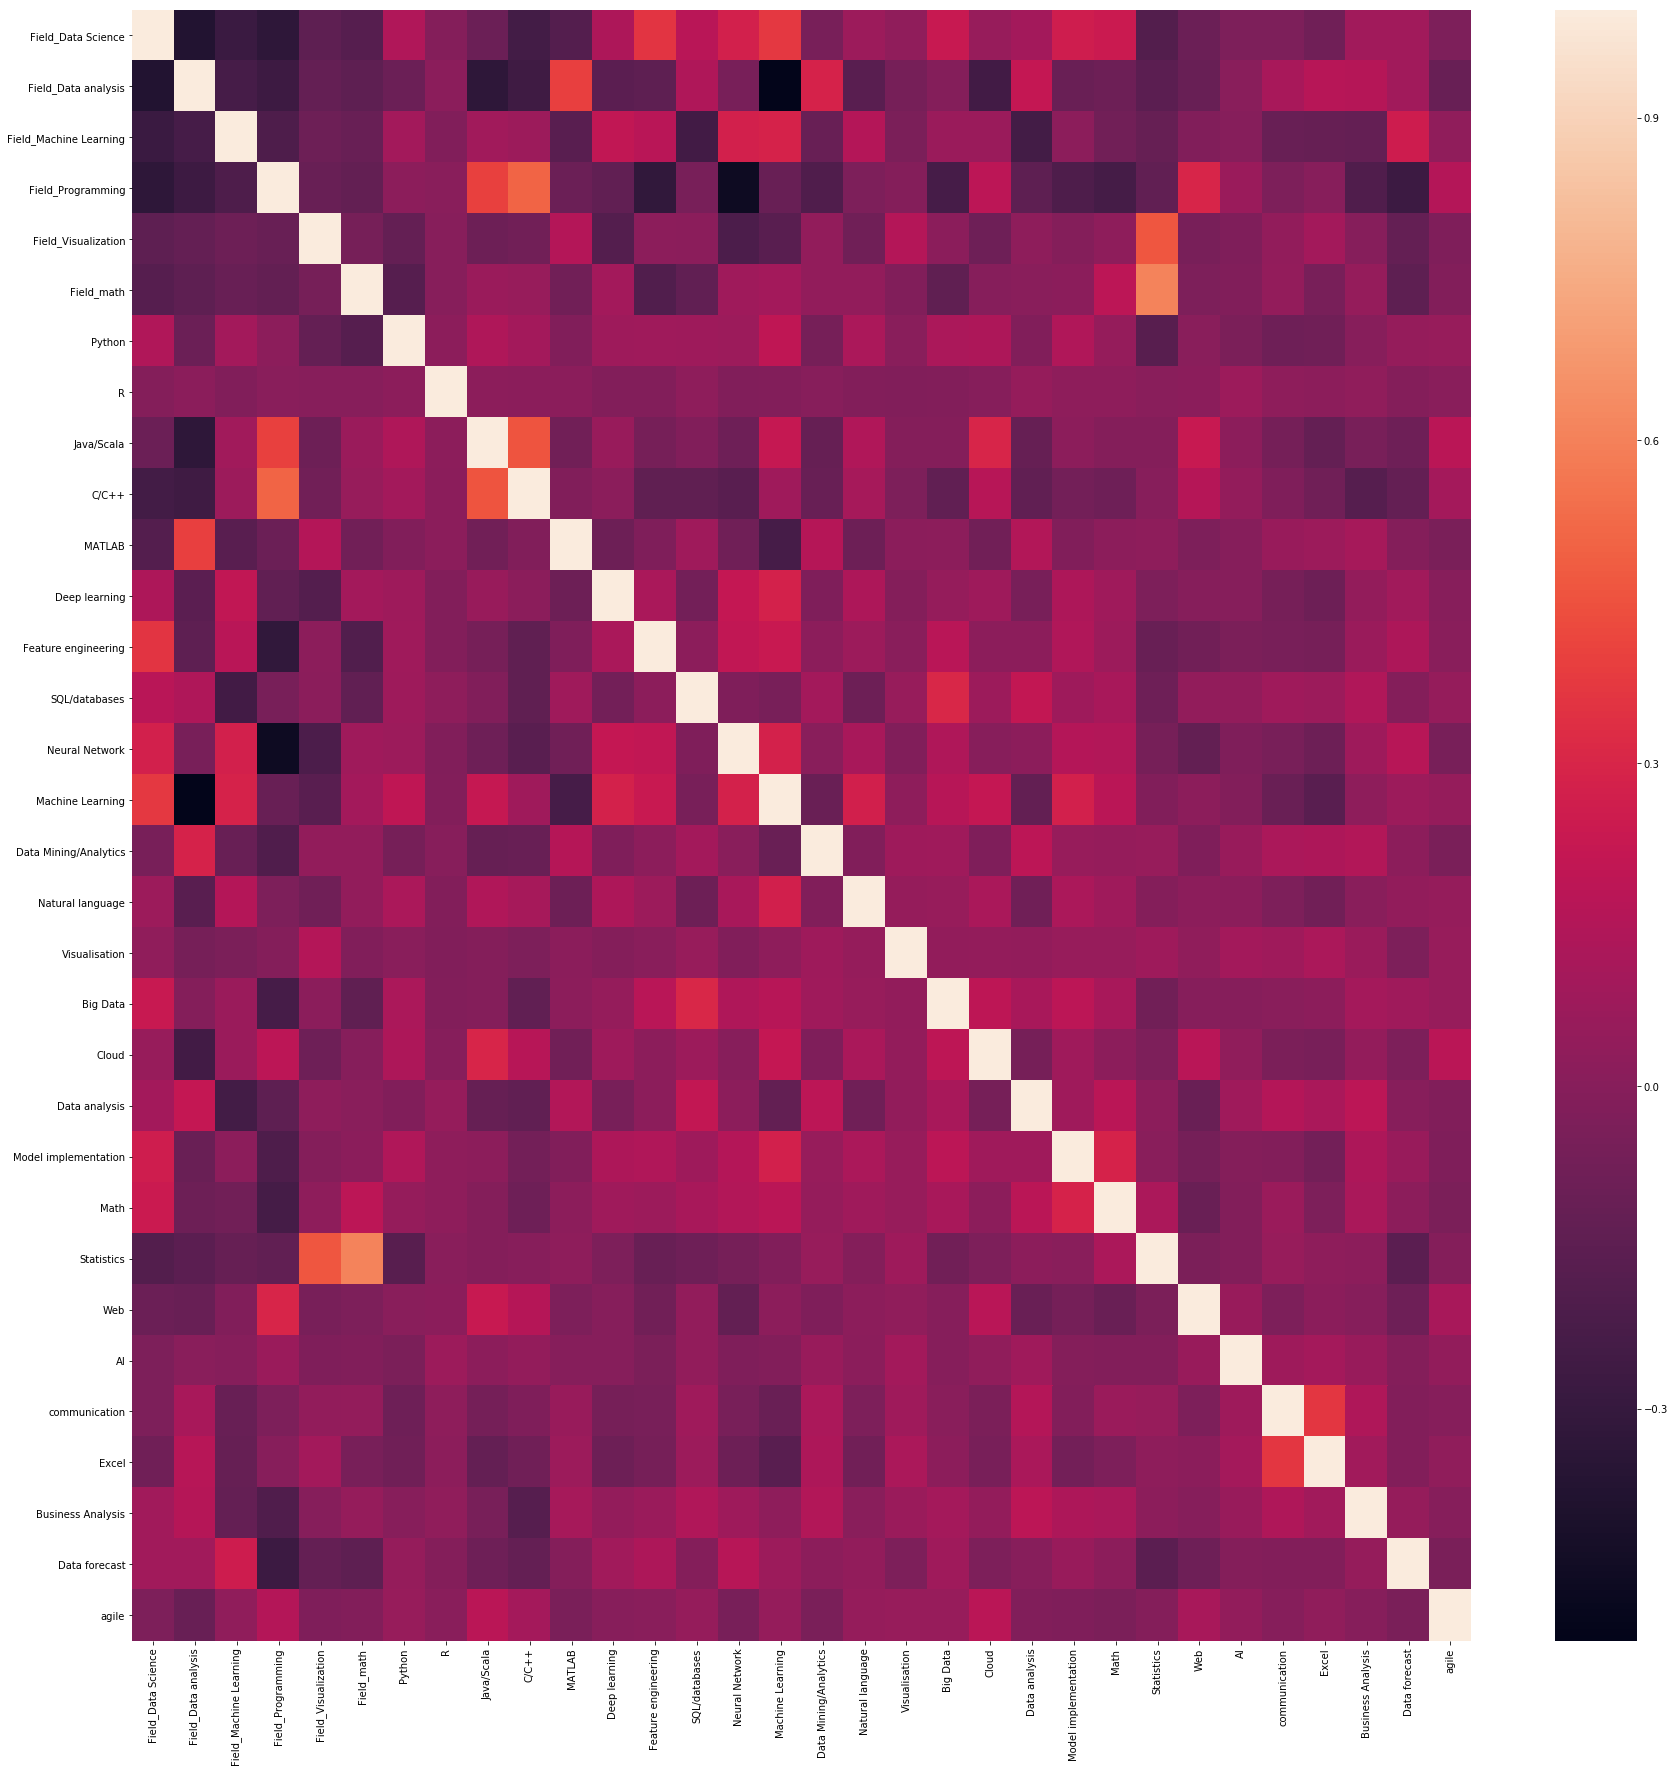

In [0]:
corr = cluster_data.corr()
fig, ax = plt.subplots(figsize=(30,30)) 
sns.heatmap(corr, ax=ax)

In [0]:
corr

,Field_Data Science,Field_Data analysis,Field_Machine Learning,Field_Programming,Field_Visualization,Field_math,Python,R,Java/Scala,C/C++,...,Model implementation,Math,Statistics,Web,AI,communication,Excel,Business Analysis,Data forecast,agile
Field_Data Science,1.000000,-0.374412,-0.279496,-0.327979,-0.148043,-0.176660,0.146863,-0.008294,-0.098926,-0.244185,...,0.256054,0.240251,-0.186301,-0.096961,-0.034949,-0.032571,-0.079270,0.090106,0.090720,-0.035612
Field_Data analysis,-0.374412,1.000000,-0.232540,-0.272878,-0.123171,-0.146981,-0.097434,0.011292,-0.328164,-0.261451,...,-0.106151,-0.092755,-0.155002,-0.109321,0.007705,0.116095,0.166328,0.159728,0.092690,-0.109767
Field_Machine Learning,-0.279496,-0.232540,1.000000,-0.203701,-0.091946,-0.109720,0.098472,-0.020065,0.090976,0.076281,...,0.019624,-0.075883,-0.115708,-0.019469,-0.004985,-0.110849,-0.117855,-0.119093,0.251909,0.032283
Field_Programming,-0.327979,-0.272878,-0.203701,1.000000,-0.107896,-0.128753,0.020660,0.009892,0.397148,0.502872,...,-0.207186,-0.240496,-0.135779,0.295815,0.067410,-0.034502,0.001933,-0.200594,-0.274131,0.153577
Field_Visualization,-0.148043,-0.123171,-0.091946,-0.107896,1.000000,-0.058116,-0.124681,0.004465,-0.093314,-0.072697,...,-0.011632,0.024125,0.466598,-0.050644,-0.029207,0.038475,0.094715,-0.004482,-0.124284,-0.026315
Field_math,-0.176660,-0.146981,-0.109720,-0.128753,-0.058116,1.000000,-0.176043,0.005328,0.065170,0.056936,...,0.016033,0.183072,0.603491,-0.031575,-0.023526,0.042772,-0.052644,0.051630,-0.148309,-0.013543
Python,0.146863,-0.097434,0.098472,0.020660,-0.124681,-0.176043,1.000000,0.021427,0.137529,0.098841,...,0.144583,0.050956,-0.169295,0.010239,-0.038740,-0.087105,-0.083232,0.001315,0.048242,0.057051
R,-0.008294,0.011292,-0.020065,0.009892,0.004465,0.005328,0.021427,1.000000,0.018917,0.014881,...,0.025859,0.024016,0.005619,0.011808,0.072851,0.024876,0.019500,0.029138,-0.012265,0.007018
Java/Scala,-0.098926,-0.328164,0.090976,0.397148,-0.093314,0.065170,0.137529,0.018917,1.000000,0.458437,...,0.021740,-0.012131,-0.011542,0.227649,0.019495,-0.062238,-0.119023,-0.053701,-0.088249,0.180278
C/C++,-0.244185,-0.261451,0.076281,0.502872,-0.072697,0.056936,0.098841,0.014881,0.458437,1.000000,...,-0.069264,-0.087589,0.000212,0.159476,0.043011,-0.029622,-0.077551,-0.176404,-0.119497,0.103396


In [0]:
cluster_data.to_csv('cluster_data.csv', index=False,encoding = "utf-8")
tmp = pd.read_csv('cluster_data.csv')
tmp.head()

,Field_Data Science,Field_Data analysis,Field_Machine Learning,Field_Programming,Field_Visualization,Field_math,Python,R,Java/Scala,C/C++,...,Model implementation,Math,Statistics,Web,AI,communication,Excel,Business Analysis,Data forecast,agile
0,0,0,1,0,0,0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0,0,1,0,0,0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
2,0,0,1,0,0,0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
3,0,0,1,0,0,0,1.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,0,0,1,0,0,0,1.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


# Total words


In [0]:
# res = []
results_dict = {}

for name in skills_keywords:
    results_dict[name] = 0
    
def skills(text, skills_keywords):
    global results_dict
    for i in range(len(text)): 
        for skill_category, skills in skills_keywords.items(): # loop over all keys and sublists in 'skills_keywords_dict'
            category_found = 0
            for skill in skills:
                if text.description[i].find(skill) != -1:     # if skill from the sublist is found, set 'category_found' to 1
                    category_found = 1
                    results_dict[skill_category] += category_found
#         print(results_dict)        
#         res.append(results_dict)

In [0]:
skills(all_job,skills_keywords)
results_dict

In [0]:
name_list = ['AI','Algorithm','Big Data','Cloud','Data Mining/Analytics','Data analysis','Feature engineering','Machine Learning'
            'Math','Model implementation','Neural Network','Programming Language','SQL/databases','Visualisation',
            'Web','communication','deep learning','natural language','statistics']

num_list = [8663,4945,13246,3509,4382,6769,1632,3665,2670,5390,3699,12211,2903,4246,1251,5812,2163,892,2110]


plt.barh(range(19), num_list, height=0.7, color='steelblue', alpha=0.8) 
plt.yticks(range(19), ['AI','Algorithm','Big Data','Cloud','Data Mining/Analytics','Data analysis','Feature engineering','Machine Learning'
            'Math','Model implementation','Neural Network','Programming Language','SQL/databases','Visualisation',
            'Web','communication','deep learning','natural language','statistics'])
plt.title('General Skill Frequency')
plt.xlabel('Skills')
plt.ylabel('Frequency')
plt.show()

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

In [0]:
us_job = us_job[pd.notnull(us_job['position'])]

In [0]:
title = us_job['position'].tolist()
title

In [0]:
X = vectorizer.fit_transform(title)

In [0]:
print(vectorizer.get_feature_names())

# 1.5 Kaggle

# Kaggle_1

In [0]:
kaggle_1 = pd.read_csv('kaggle_1.csv',encoding = 'ISO-8859-1')
kaggle_1.head()

In [0]:
kaggle_1 = kaggle_1[pd.notnull(kaggle_1['CurrentJobTitleSelect'])]
kaggle_1.head()

# MLToolNextYearSelect

In [0]:
kaggle_1['MLToolNextYearSelect'].value_counts()

In [0]:
kaggle_1 = kaggle_1[kaggle_1['MLToolNextYearSelect']!="I don't plan on learning a new tool/technology"]

kaggle_1.loc[kaggle_1.MLToolNextYearSelect=='SAS Enterprise Miner','MLToolNextYearSelect']='SAS'
kaggle_1.loc[kaggle_1.MLToolNextYearSelect=='SAS Enterprise Miner','MLToolNextYearSelect']='SAS Base'
kaggle_1.loc[kaggle_1.MLToolNextYearSelect=='Amazon Machine Learning','MLToolNextYearSelect']='Machine Learning' 
kaggle_1.loc[kaggle_1.MLToolNextYearSelect=='Microsoft Azure Machine Learning','MLToolNextYearSelect']='Machine Learning'
kaggle_1.loc[kaggle_1.MLToolNextYearSelect=='Google Cloud Compute','MLToolNextYearSelect']='Cloud computing'
kaggle_1.loc[kaggle_1.MLToolNextYearSelect=='Cloudera','MLToolNextYearSelect']='Cloud computing'          
kaggle_1.loc[kaggle_1.MLToolNextYearSelect=='Microsoft SQL Server Data Mining','MLToolNextYearSelect']='SQL'       
kaggle_1.loc[kaggle_1.MLToolNextYearSelect=='NoSQL','MLToolNextYearSelect']='SQL'    
kaggle_1.loc[kaggle_1.MLToolNextYearSelect=='Microsoft R Server (Formerly Revolution Analytics)']='R'    


In [0]:
counts = kaggle_1['MLToolNextYearSelect'].value_counts()
kaggle_1['remain'] = kaggle_1.MLToolNextYearSelect.isin(counts.index[counts > 50])
kaggle_1 = kaggle_1[kaggle_1.remain!=False]
kaggle_1['MLToolNextYearSelect'].value_counts()

# MLMethodNextYearSelect

In [0]:
kaggle_1['MLMethodNextYearSelect'].value_counts()

In [0]:
counts = kaggle_1['MLMethodNextYearSelect'].value_counts()
kaggle_1['remain'] = kaggle_1.MLMethodNextYearSelect.isin(counts.index[counts > 90])
kaggle_1 = kaggle_1[kaggle_1.remain!=False]
kaggle_1['MLMethodNextYearSelect'].value_counts()

# Language

In [0]:
kaggle_1['LanguageRecommendationSelect'].value_counts()

Python      4291
R           1620
SQL          247
C/C++/C#     151
Matlab       111
Scala         72
Java          60
Other         38
SAS           34
Julia         19
Stata         16
Haskell        9
F#             1
Name: LanguageRecommendationSelect, dtype: int64

In [0]:
counts = kaggle_1['LanguageRecommendationSelect'].value_counts()
kaggle_1['remain'] = kaggle_1.LanguageRecommendationSelect.isin(counts.index[counts > 50])
kaggle_1 = kaggle_1[kaggle_1.remain!=False]
kaggle_1['LanguageRecommendationSelect'].value_counts()

Python      4291
R           1620
SQL          247
C/C++/C#     151
Matlab       111
Scala         72
Java          60
Name: LanguageRecommendationSelect, dtype: int64

# MLTechniquesSelect

In [0]:
kaggle_1['MLTechniquesSelect'].value_counts()

Logistic Regression                                                                                                                                                                                                                                                  385
Decision Trees - Random Forests,Logistic Regression                                                                                                                                                                                                                  207
Other (please specify; separate by semi-colon)                                                                                                                                                                                                                       172
Decision Trees - Gradient Boosted Machines,Decision Trees - Random Forests,Logistic Regression                                                                                                               

In [0]:
counts = kaggle_1['MLTechniquesSelect'].value_counts()
kaggle_1['remain'] = kaggle_1.MLTechniquesSelect.isin(counts.index[counts > 50])
kaggle_1 = kaggle_1[kaggle_1.remain!=False]
kaggle_1['MLTechniquesSelect'].value_counts()

Logistic Regression                                                                                                                                                                        385
Decision Trees - Random Forests,Logistic Regression                                                                                                                                        207
Other (please specify; separate by semi-colon)                                                                                                                                             172
Decision Trees - Gradient Boosted Machines,Decision Trees - Random Forests,Logistic Regression                                                                                             130
Neural Networks - CNNs                                                                                                                                                                     117
Decision Trees - Gradient Boosted Machines,De

# Kaggle_salary

In [0]:
kaggle_salary = pd.read_csv('kaggle_salary.csv',encoding = 'ISO-8859-1', error_bad_lines=False)
kaggle_salary = kaggle_salary[1:]
kaggle_salary.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,3,9,11,13,22,24,25,26,27,28,29,45,57,65,84,86,88,108,110,124,126,151,195,224,250,263,265,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,305,307,326,327,330,342,386,395) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,Time from Start to Finish (seconds),Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6,Q6_OTHER_TEXT,...,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,Q50_OTHER_TEXT,index
1,2,434,Male,-1,30-34,Indonesia,Bachelorâs degree,Engineering (non-computer focused),Other,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0.0
2,3,718,Female,-1,30-34,United States of America,Masterâs degree,"Computer science (software engineering, etc.)",Data Scientist,-1,...,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN,-1,1.0
3,5,731,Male,-1,22-24,India,Masterâs degree,Mathematics or statistics,Data Analyst,-1,...,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1,2.0
4,7,959,Male,-1,35-39,Chile,Doctoral degree,"Information technology, networking, or system ...",Other,1,...,Too expensive,NaN,NaN,NaN,NaN,I had never considered making my work easier f...,NaN,NaN,-1,3.0
5,8,1758,Male,-1,18-21,India,Masterâs degree,"Information technology, networking, or system ...",Other,2,...,NaN,NaN,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1,4.0


In [0]:
kaggle_salary= kaggle_salary.drop(['Time from Start to Finish (seconds)','Q1','Q1_OTHER_TEXT','Q2','Q3'],axis = 1)
kaggle_salary= kaggle_salary.drop(['Q7','Q6_OTHER_TEXT','Q7_OTHER_TEXT','Q8'],axis = 1)
kaggle_salary= kaggle_salary.drop(['Q11_OTHER_TEXT','Q12_OTHER_TEXT','Q12_Part_1_TEXT','Q12_Part_2_TEXT','Q12_Part_3_TEXT','Q12_Part_4_TEXT','Q12_Part_5_TEXT'],axis = 1)
kaggle_salary= kaggle_salary.drop(['Q13_Part_15','Q13_OTHER_TEXT'],axis = 1)
kaggle_salary= kaggle_salary.drop(['Q14_Part_1','Q14_Part_2','Q14_Part_3','Q14_Part_4','Q14_Part_5','Q14_Part_6','Q14_Part_7',
                                   'Q14_Part_8','Q14_Part_9','Q14_Part_10','Q14_Part_11','Q14_OTHER_TEXT'],axis = 1)
kaggle_salary= kaggle_salary.drop(['Q15_Part_1','Q15_Part_2','Q15_Part_3','Q15_Part_4','Q15_Part_5','Q15_Part_6','Q15_Part_7','Q15_OTHER_TEXT'],axis = 1)
kaggle_salary= kaggle_salary.drop(['Q16_OTHER_TEXT','Q17_OTHER_TEXT','Q18_OTHER_TEXT','Q19_Part_18','Q19_Part_19','Q19_OTHER_TEXT'],axis = 1)

kaggle_salary.head()

,Unnamed: 0,Q4,Q5,Q6,Q9,Q10,Q11_Part_1,Q11_Part_2,Q11_Part_3,Q11_Part_4,...,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,Q50_OTHER_TEXT,index
1,2,Bachelorâs degree,Engineering (non-computer focused),Other,18668,No (we do not use ML methods),NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0.0
2,3,Masterâs degree,"Computer science (software engineering, etc.)",Data Scientist,2726,I do not know,Analyze and understand data to influence produ...,NaN,NaN,NaN,...,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN,-1,1.0
3,5,Masterâs degree,Mathematics or statistics,Data Analyst,682,I do not know,NaN,NaN,NaN,NaN,...,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1,2.0
4,7,Doctoral degree,"Information technology, networking, or system ...",Other,11957,No (we do not use ML methods),NaN,NaN,NaN,NaN,...,Too expensive,NaN,NaN,NaN,NaN,I had never considered making my work easier f...,NaN,NaN,-1,3.0
5,8,Masterâs degree,"Information technology, networking, or system ...",Other,2696,"We recently started using ML methods (i.e., mo...",NaN,Build and/or run a machine learning service th...,NaN,NaN,...,NaN,NaN,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1,4.0


In [0]:
new_data = kaggle_salary.iloc[:,:66] 
new_data = new_data.drop(['Unnamed: 0'],axis = 1)
new_data

,Q4,Q5,Q6,Q9,Q10,Q11_Part_1,Q11_Part_2,Q11_Part_3,Q11_Part_4,Q11_Part_5,...,Q19_Part_9,Q19_Part_10,Q19_Part_11,Q19_Part_12,Q19_Part_13,Q19_Part_14,Q19_Part_15,Q19_Part_16,Q19_Part_17,Q20
1,Bachelorâs degree,Engineering (non-computer focused),Other,18668,No (we do not use ML methods),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Masterâs degree,"Computer science (software engineering, etc.)",Data Scientist,2726,I do not know,Analyze and understand data to influence produ...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Masterâs degree,Mathematics or statistics,Data Analyst,682,I do not know,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Prophet,NaN,NaN,NaN,NaN,NaN,NaN
4,Doctoral degree,"Information technology, networking, or system ...",Other,11957,No (we do not use ML methods),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Masterâs degree,"Information technology, networking, or system ...",Other,2696,"We recently started using ML methods (i.e., mo...",NaN,Build and/or run a machine learning service th...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Keras
6,Masterâs degree,Engineering (non-computer focused),Software Engineer,21152,"We have well established ML methods (i.e., mod...",NaN,Build and/or run a machine learning service th...,Build and/or run the data infrastructure that ...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Scikit-Learn
7,Masterâs degree,Engineering (non-computer focused),Data Scientist,132826,"We recently started using ML methods (i.e., mo...",NaN,Build and/or run a machine learning service th...,NaN,NaN,NaN,...,NaN,Xgboost,NaN,NaN,randomForest,NaN,NaN,NaN,NaN,Scikit-Learn
8,Doctoral degree,Mathematics or statistics,Student,38246,"We have well established ML methods (i.e., mod...",NaN,NaN,NaN,Build prototypes to explore applying machine l...,Do research that advances the state of the art...,...,Caret,Xgboost,mlr,NaN,randomForest,NaN,NaN,NaN,NaN,Scikit-Learn
9,Bachelorâs degree,Mathematics or statistics,Research Assistant,35826,We are exploring ML methods (and may one day p...,Analyze and understand data to influence produ...,NaN,NaN,Build prototypes to explore applying machine l...,Do research that advances the state of the art...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TensorFlow
10,Bachelorâs degree,"A business discipline (accounting, economics, ...",Data Analyst,19903,"We have well established ML methods (i.e., mod...",Analyze and understand data to influence produ...,NaN,NaN,NaN,NaN,...,NaN,Xgboost,NaN,NaN,randomForest,lightgbm,NaN,NaN,NaN,Scikit-Learn


In [0]:
Q22 = kaggle_salary.iloc[:,[81]] 
Q27 = kaggle_salary.iloc[:,87:105] 
Q28 = kaggle_salary.iloc[:,108:149] 
Q29 = kaggle_salary.iloc[:,152:178] 
Q30 = kaggle_salary.iloc[:,181:204] 

new_data = pd.concat([new_data,Q27,Q28,Q29,Q30],axis = 1)
new_data


,Q4,Q5,Q6,Q9,Q10,Q11_Part_1,Q11_Part_2,Q11_Part_3,Q11_Part_4,Q11_Part_5,...,Q30_Part_14,Q30_Part_15,Q30_Part_16,Q30_Part_17,Q30_Part_18,Q30_Part_19,Q30_Part_20,Q30_Part_21,Q30_Part_22,Q30_Part_23
1,Bachelorâs degree,Engineering (non-computer focused),Other,18668,No (we do not use ML methods),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Masterâs degree,"Computer science (software engineering, etc.)",Data Scientist,2726,I do not know,Analyze and understand data to influence produ...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Masterâs degree,Mathematics or statistics,Data Analyst,682,I do not know,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Doctoral degree,"Information technology, networking, or system ...",Other,11957,No (we do not use ML methods),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Masterâs degree,"Information technology, networking, or system ...",Other,2696,"We recently started using ML methods (i.e., mo...",NaN,Build and/or run a machine learning service th...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Masterâs degree,Engineering (non-computer focused),Software Engineer,21152,"We have well established ML methods (i.e., mod...",NaN,Build and/or run a machine learning service th...,Build and/or run the data infrastructure that ...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Masterâs degree,Engineering (non-computer focused),Data Scientist,132826,"We recently started using ML methods (i.e., mo...",NaN,Build and/or run a machine learning service th...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Doctoral degree,Mathematics or statistics,Student,38246,"We have well established ML methods (i.e., mod...",NaN,NaN,NaN,Build prototypes to explore applying machine l...,Do research that advances the state of the art...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Bachelorâs degree,Mathematics or statistics,Research Assistant,35826,We are exploring ML methods (and may one day p...,Analyze and understand data to influence produ...,NaN,NaN,Build prototypes to explore applying machine l...,Do research that advances the state of the art...,...,NaN,NaN,NaN,NaN,Azure SQL Data Warehouse,NaN,NaN,NaN,NaN,NaN
10,Bachelorâs degree,"A business discipline (accounting, economics, ...",Data Analyst,19903,"We have well established ML methods (i.e., mod...",Analyze and understand data to influence produ...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
job_info = new_data
job_info.head()

,Q4,Q5,Q6,Q9,Q10,Q11_Part_1,Q11_Part_2,Q11_Part_3,Q11_Part_4,Q11_Part_5,...,Q30_Part_14,Q30_Part_15,Q30_Part_16,Q30_Part_17,Q30_Part_18,Q30_Part_19,Q30_Part_20,Q30_Part_21,Q30_Part_22,Q30_Part_23
1,Bachelorâs degree,Engineering (non-computer focused),Other,18668,No (we do not use ML methods),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Masterâs degree,"Computer science (software engineering, etc.)",Data Scientist,2726,I do not know,Analyze and understand data to influence produ...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Masterâs degree,Mathematics or statistics,Data Analyst,682,I do not know,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Doctoral degree,"Information technology, networking, or system ...",Other,11957,No (we do not use ML methods),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Masterâs degree,"Information technology, networking, or system ...",Other,2696,"We recently started using ML methods (i.e., mo...",NaN,Build and/or run a machine learning service th...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
job_info.loc[:,'Q10':'Q30_Part_23'] = job_info.loc[:,'Q10':'Q30_Part_23'].fillna('Unselected')
job_info.head()

,Q4,Q5,Q6,Q9,Q10,Q11_Part_1,Q11_Part_2,Q11_Part_3,Q11_Part_4,Q11_Part_5,...,Q30_Part_14,Q30_Part_15,Q30_Part_16,Q30_Part_17,Q30_Part_18,Q30_Part_19,Q30_Part_20,Q30_Part_21,Q30_Part_22,Q30_Part_23
1,Bachelorâs degree,Engineering (non-computer focused),Other,18668,No (we do not use ML methods),Unselected,Unselected,Unselected,Unselected,Unselected,...,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected
2,Masterâs degree,"Computer science (software engineering, etc.)",Data Scientist,2726,I do not know,Analyze and understand data to influence produ...,Unselected,Unselected,Unselected,Unselected,...,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected
3,Masterâs degree,Mathematics or statistics,Data Analyst,682,I do not know,Unselected,Unselected,Unselected,Unselected,Unselected,...,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected
4,Doctoral degree,"Information technology, networking, or system ...",Other,11957,No (we do not use ML methods),Unselected,Unselected,Unselected,Unselected,Unselected,...,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected
5,Masterâs degree,"Information technology, networking, or system ...",Other,2696,"We recently started using ML methods (i.e., mo...",Unselected,Build and/or run a machine learning service th...,Unselected,Unselected,Unselected,...,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected


# Kill > 20000

In [0]:
job_info['Q9']=pd.to_numeric(job_info['Q9'])

In [0]:
job_info.drop(job_info[job_info['Q9'] < 5000].index)

,Q4,Q5,Q6,Q9,Q10,Q11_Part_1,Q11_Part_2,Q11_Part_3,Q11_Part_4,Q11_Part_5,...,Q30_Part_14,Q30_Part_15,Q30_Part_16,Q30_Part_17,Q30_Part_18,Q30_Part_19,Q30_Part_20,Q30_Part_21,Q30_Part_22,Q30_Part_23
1,Bachelorâs degree,Engineering (non-computer focused),Other,18668,No (we do not use ML methods),Unselected,Unselected,Unselected,Unselected,Unselected,...,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected
4,Doctoral degree,"Information technology, networking, or system ...",Other,11957,No (we do not use ML methods),Unselected,Unselected,Unselected,Unselected,Unselected,...,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected
6,Masterâs degree,Engineering (non-computer focused),Software Engineer,21152,"We have well established ML methods (i.e., mod...",Unselected,Build and/or run a machine learning service th...,Build and/or run the data infrastructure that ...,Unselected,Unselected,...,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected
7,Masterâs degree,Engineering (non-computer focused),Data Scientist,132826,"We recently started using ML methods (i.e., mo...",Unselected,Build and/or run a machine learning service th...,Unselected,Unselected,Unselected,...,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected
8,Doctoral degree,Mathematics or statistics,Student,38246,"We have well established ML methods (i.e., mod...",Unselected,Unselected,Unselected,Build prototypes to explore applying machine l...,Do research that advances the state of the art...,...,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected
9,Bachelorâs degree,Mathematics or statistics,Research Assistant,35826,We are exploring ML methods (and may one day p...,Analyze and understand data to influence produ...,Unselected,Unselected,Build prototypes to explore applying machine l...,Do research that advances the state of the art...,...,Unselected,Unselected,Unselected,Unselected,Azure SQL Data Warehouse,Unselected,Unselected,Unselected,Unselected,Unselected
10,Bachelorâs degree,"A business discipline (accounting, economics, ...",Data Analyst,19903,"We have well established ML methods (i.e., mod...",Analyze and understand data to influence produ...,Unselected,Unselected,Unselected,Unselected,...,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected
11,Masterâs degree,Engineering (non-computer focused),Data Scientist,30633,We use ML methods for generating insights (but...,Analyze and understand data to influence produ...,Build and/or run a machine learning service th...,Unselected,Unselected,Unselected,...,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected
12,Masterâs degree,Environmental science or geology,Data Scientist,51205,We are exploring ML methods (and may one day p...,Unselected,Unselected,Unselected,Build prototypes to explore applying machine l...,Unselected,...,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected
14,Some college/university study without earning ...,"Computer science (software engineering, etc.)",Other,124197,No (we do not use ML methods),Analyze and understand data to influence produ...,Unselected,Build and/or run the data infrastructure that ...,Unselected,Unselected,...,Unselected,Unselected,Unselected,Unselected,Azure SQL Data Warehouse,Azure HDInsight,Unselected,Unselected,Unselected,Unselected


# Q4

In [0]:
job_info.Q4.replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)
job_info.loc[job_info.Q4=='I prefer not to answer','Q4']='None'
job_info.loc[job_info.Q4=='No formal education past high school','Q4']='None'
job_info['Q4'].value_counts()

Masters degree                                                      2819
Bachelors degree                                                    1702
Doctoral degree                                                     1058
Some college/university study without earning a bachelors degree     204
Professional degree                                                  145
None                                                                  67
Name: Q4, dtype: int64

# Q5

In [0]:
job_info.loc[job_info.Q5=='I never declared a major','Q5']='None'
job_info['Q5'].value_counts()

Computer science (software engineering, etc.)                    2150
Engineering (non-computer focused)                                967
Mathematics or statistics                                         865
A business discipline (accounting, economics, finance, etc.)      528
Physics or astronomy                                              338
Medical or life sciences (biology, chemistry, medicine, etc.)     276
Information technology, networking, or system administration      225
Other                                                             205
Social sciences (anthropology, psychology, sociology, etc.)       199
Humanities (history, literature, philosophy, etc.)                 89
Environmental science or geology                                   74
Fine arts or performing arts                                       25
None                                                               23
Name: Q5, dtype: int64

# Q12

In [0]:
# job_info.loc[job_info.Q5=='I never declared a major','Q5']='None'
job_info.loc[job_info.Q12_MULTIPLE_CHOICE=='Local or hosted development environments (RStudio, JupyterLab, etc.)','Q12_MULTIPLE_CHOICE']='Local or hosted development environments likRStudio and JupyterLab'
job_info.loc[job_info.Q12_MULTIPLE_CHOICE=='Advanced statistical software (SPSS, SAS, etc.)','Q12_MULTIPLE_CHOICE']='Advanced statistical software like SPSS and SAS'
job_info.loc[job_info.Q12_MULTIPLE_CHOICE=='Cloud-based data software & APIs (AWS, GCP, Azure, etc.)','Q12_MULTIPLE_CHOICE']='Cloud-based data software & APIs like AWS and GCP'
job_info.loc[job_info.Q12_MULTIPLE_CHOICE=='Business intelligence software (Salesforce, Tableau, Spotfire, etc.)','Q12_MULTIPLE_CHOICE']='Business intelligence software like Salesforce'
job_info.loc[job_info.Q12_MULTIPLE_CHOICE=='Basic statistical software (Microsoft Excel, Google Sheets, etc.)','Q12_MULTIPLE_CHOICE']='Basic statistical software like Excel and Google Sheets'

job_info['Q12_MULTIPLE_CHOICE'].value_counts()

Local or hosted development environments likRStudio and JupyterLab    3207
Basic statistical software like Excel and Google Sheets               1046
Other                                                                  514
Advanced statistical software like SPSS and SAS                        452
Cloud-based data software & APIs like AWS and GCP                      401
Business intelligence software like Salesforce                         368
Unselected                                                               7
Name: Q12_MULTIPLE_CHOICE, dtype: int64

# job_info_select

In [0]:
job_info_select = job_info[['Q5','Q12_MULTIPLE_CHOICE','Q17','Q18','Q20']]
job_info_select.columns=['undergradute magor','Analyze tools','Programming Language','Learn Programming Language','ML Library']
job_info_select = pd.get_dummies(job_info_select)
job_info_select.head()

,"undergradute magor_A business discipline (accounting, economics, finance, etc.)","undergradute magor_Computer science (software engineering, etc.)",undergradute magor_Engineering (non-computer focused),undergradute magor_Environmental science or geology,undergradute magor_Fine arts or performing arts,"undergradute magor_Humanities (history, literature, philosophy, etc.)","undergradute magor_Information technology, networking, or system administration",undergradute magor_Mathematics or statistics,"undergradute magor_Medical or life sciences (biology, chemistry, medicine, etc.)",undergradute magor_None,...,ML Library_PyTorch,ML Library_Scikit-Learn,ML Library_Spark MLlib,ML Library_TensorFlow,ML Library_Unselected,ML Library_Xgboost,ML Library_catboost,ML Library_lightgbm,ML Library_mlr,ML Library_randomForest
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Job_title

In [0]:
job_title = job_info[['Q6']]
job_title.columns=['Job_title']
job_title.head()

,Job_title
1,Other
2,Data Scientist
3,Data Analyst
4,Other
5,Other


# salary

In [0]:
salary = kaggle_salary[['Q9']]
salary.columns = ['salary']
salary.tail()

,salary
5991,54080
5992,3903
5993,500000
5994,7490
5995,10249


# One_hot encoding

In [0]:
job_info = job_info.drop(['Q10','Q12_MULTIPLE_CHOICE','Q17','Q18','Q20'],axis = 1)
job_info.head()

,Q4,Q5,Q6,Q9,Q11_Part_1,Q11_Part_2,Q11_Part_3,Q11_Part_4,Q11_Part_5,Q11_Part_6,...,Q30_Part_14,Q30_Part_15,Q30_Part_16,Q30_Part_17,Q30_Part_18,Q30_Part_19,Q30_Part_20,Q30_Part_21,Q30_Part_22,Q30_Part_23
1,Bachelors degree,Engineering (non-computer focused),Other,18668,Unselected,Unselected,Unselected,Unselected,Unselected,None of these activities are an important part...,...,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected
2,Masters degree,"Computer science (software engineering, etc.)",Data Scientist,2726,Analyze and understand data to influence produ...,Unselected,Unselected,Unselected,Unselected,Unselected,...,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected
3,Masters degree,Mathematics or statistics,Data Analyst,682,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,...,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected
4,Doctoral degree,"Information technology, networking, or system ...",Other,11957,Unselected,Unselected,Unselected,Unselected,Unselected,None of these activities are an important part...,...,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected
5,Masters degree,"Information technology, networking, or system ...",Other,2696,Unselected,Build and/or run a machine learning service th...,Unselected,Unselected,Unselected,Unselected,...,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected,Unselected


In [0]:
job_info['Q6'].value_counts()

Data Scientist             1465
Student                     917
Software Engineer           812
Data Analyst                584
Other                       395
Research Scientist          377
Consultant                  223
Business Analyst            221
Data Engineer               206
Manager                     180
Research Assistant          157
Product/Project Manager     117
Chief Officer                99
Statistician                 69
Principal Investigator       43
DBA/Database Engineer        40
Marketing Analyst            34
Salesperson                  29
Developer Advocate           25
Data Journalist               2
Name: Q6, dtype: int64

In [0]:
# job_onehot = pd.get_dummies(data=job_info, columns=['Q4','Q5','Q6','Q9'])
job_onehot = job_info.loc[:,'Q11_Part_1':'Q30_Part_9']

for a in job_onehot.columns:
    job_onehot.loc[job_onehot[a]=='Unselected',a]=0
    b=a[-2:]
    b=re.findall(r'\d+',b)
    job_onehot.loc[job_onehot[a]!=0,a]=b
    
job_onehot.head()

,Q11_Part_1,Q11_Part_2,Q11_Part_3,Q11_Part_4,Q11_Part_5,Q11_Part_6,Q11_Part_7,Q13_Part_1,Q13_Part_2,Q13_Part_3,...,Q29_Part_26,Q30_Part_1,Q30_Part_2,Q30_Part_3,Q30_Part_4,Q30_Part_5,Q30_Part_6,Q30_Part_7,Q30_Part_8,Q30_Part_9
1,0,0,0,0,0,6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,7,0,2,0,...,0,0,0,0,4,0,0,0,0,0
4,0,0,0,0,0,6,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
5,0,2,0,0,0,0,0,1,0,3,...,0,0,0,0,0,0,0,0,0,0


In [0]:
for a in job_onehot.columns:
    job_onehot.loc[job_onehot[a] != 0,a] = 1
job_onehot.head()

,Q11_Part_1,Q11_Part_2,Q11_Part_3,Q11_Part_4,Q11_Part_5,Q11_Part_6,Q11_Part_7,Q13_Part_1,Q13_Part_2,Q13_Part_3,...,Q29_Part_26,Q30_Part_1,Q30_Part_2,Q30_Part_3,Q30_Part_4,Q30_Part_5,Q30_Part_6,Q30_Part_7,Q30_Part_8,Q30_Part_9
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [0]:
job_info_select.head()

,"undergradute magor_A business discipline (accounting, economics, finance, etc.)","undergradute magor_Computer science (software engineering, etc.)",undergradute magor_Engineering (non-computer focused),undergradute magor_Environmental science or geology,undergradute magor_Fine arts or performing arts,"undergradute magor_Humanities (history, literature, philosophy, etc.)","undergradute magor_Information technology, networking, or system administration",undergradute magor_Mathematics or statistics,"undergradute magor_Medical or life sciences (biology, chemistry, medicine, etc.)",undergradute magor_None,...,ML Library_PyTorch,ML Library_Scikit-Learn,ML Library_Spark MLlib,ML Library_TensorFlow,ML Library_Unselected,ML Library_Xgboost,ML Library_catboost,ML Library_lightgbm,ML Library_mlr,ML Library_randomForest
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Test_data

In [0]:
salary_x = pd.concat([job_info_select,job_onehot], axis = 1)
# salary_x = job_info_select
salary_x.head()

,"undergradute magor_A business discipline (accounting, economics, finance, etc.)","undergradute magor_Computer science (software engineering, etc.)",undergradute magor_Engineering (non-computer focused),undergradute magor_Environmental science or geology,undergradute magor_Fine arts or performing arts,"undergradute magor_Humanities (history, literature, philosophy, etc.)","undergradute magor_Information technology, networking, or system administration",undergradute magor_Mathematics or statistics,"undergradute magor_Medical or life sciences (biology, chemistry, medicine, etc.)",undergradute magor_None,...,Q29_Part_26,Q30_Part_1,Q30_Part_2,Q30_Part_3,Q30_Part_4,Q30_Part_5,Q30_Part_6,Q30_Part_7,Q30_Part_8,Q30_Part_9
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [0]:
salary_y = salary
salary_y['salary']=pd.to_numeric(salary_y['salary'])
salary_y.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,salary
1,18668
2,2726
3,682
4,11957
5,2696


In [0]:
total_salary = pd.concat([salary_y,salary_x], axis = 1)
total_salary.head()

,salary,"undergradute magor_A business discipline (accounting, economics, finance, etc.)","undergradute magor_Computer science (software engineering, etc.)",undergradute magor_Engineering (non-computer focused),undergradute magor_Environmental science or geology,undergradute magor_Fine arts or performing arts,"undergradute magor_Humanities (history, literature, philosophy, etc.)","undergradute magor_Information technology, networking, or system administration",undergradute magor_Mathematics or statistics,"undergradute magor_Medical or life sciences (biology, chemistry, medicine, etc.)",...,Q29_Part_26,Q30_Part_1,Q30_Part_2,Q30_Part_3,Q30_Part_4,Q30_Part_5,Q30_Part_6,Q30_Part_7,Q30_Part_8,Q30_Part_9
1,18668,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2726,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,682,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4,11957,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2696,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [0]:
total_salary['salary']=pd.to_numeric(total_salary['salary'])

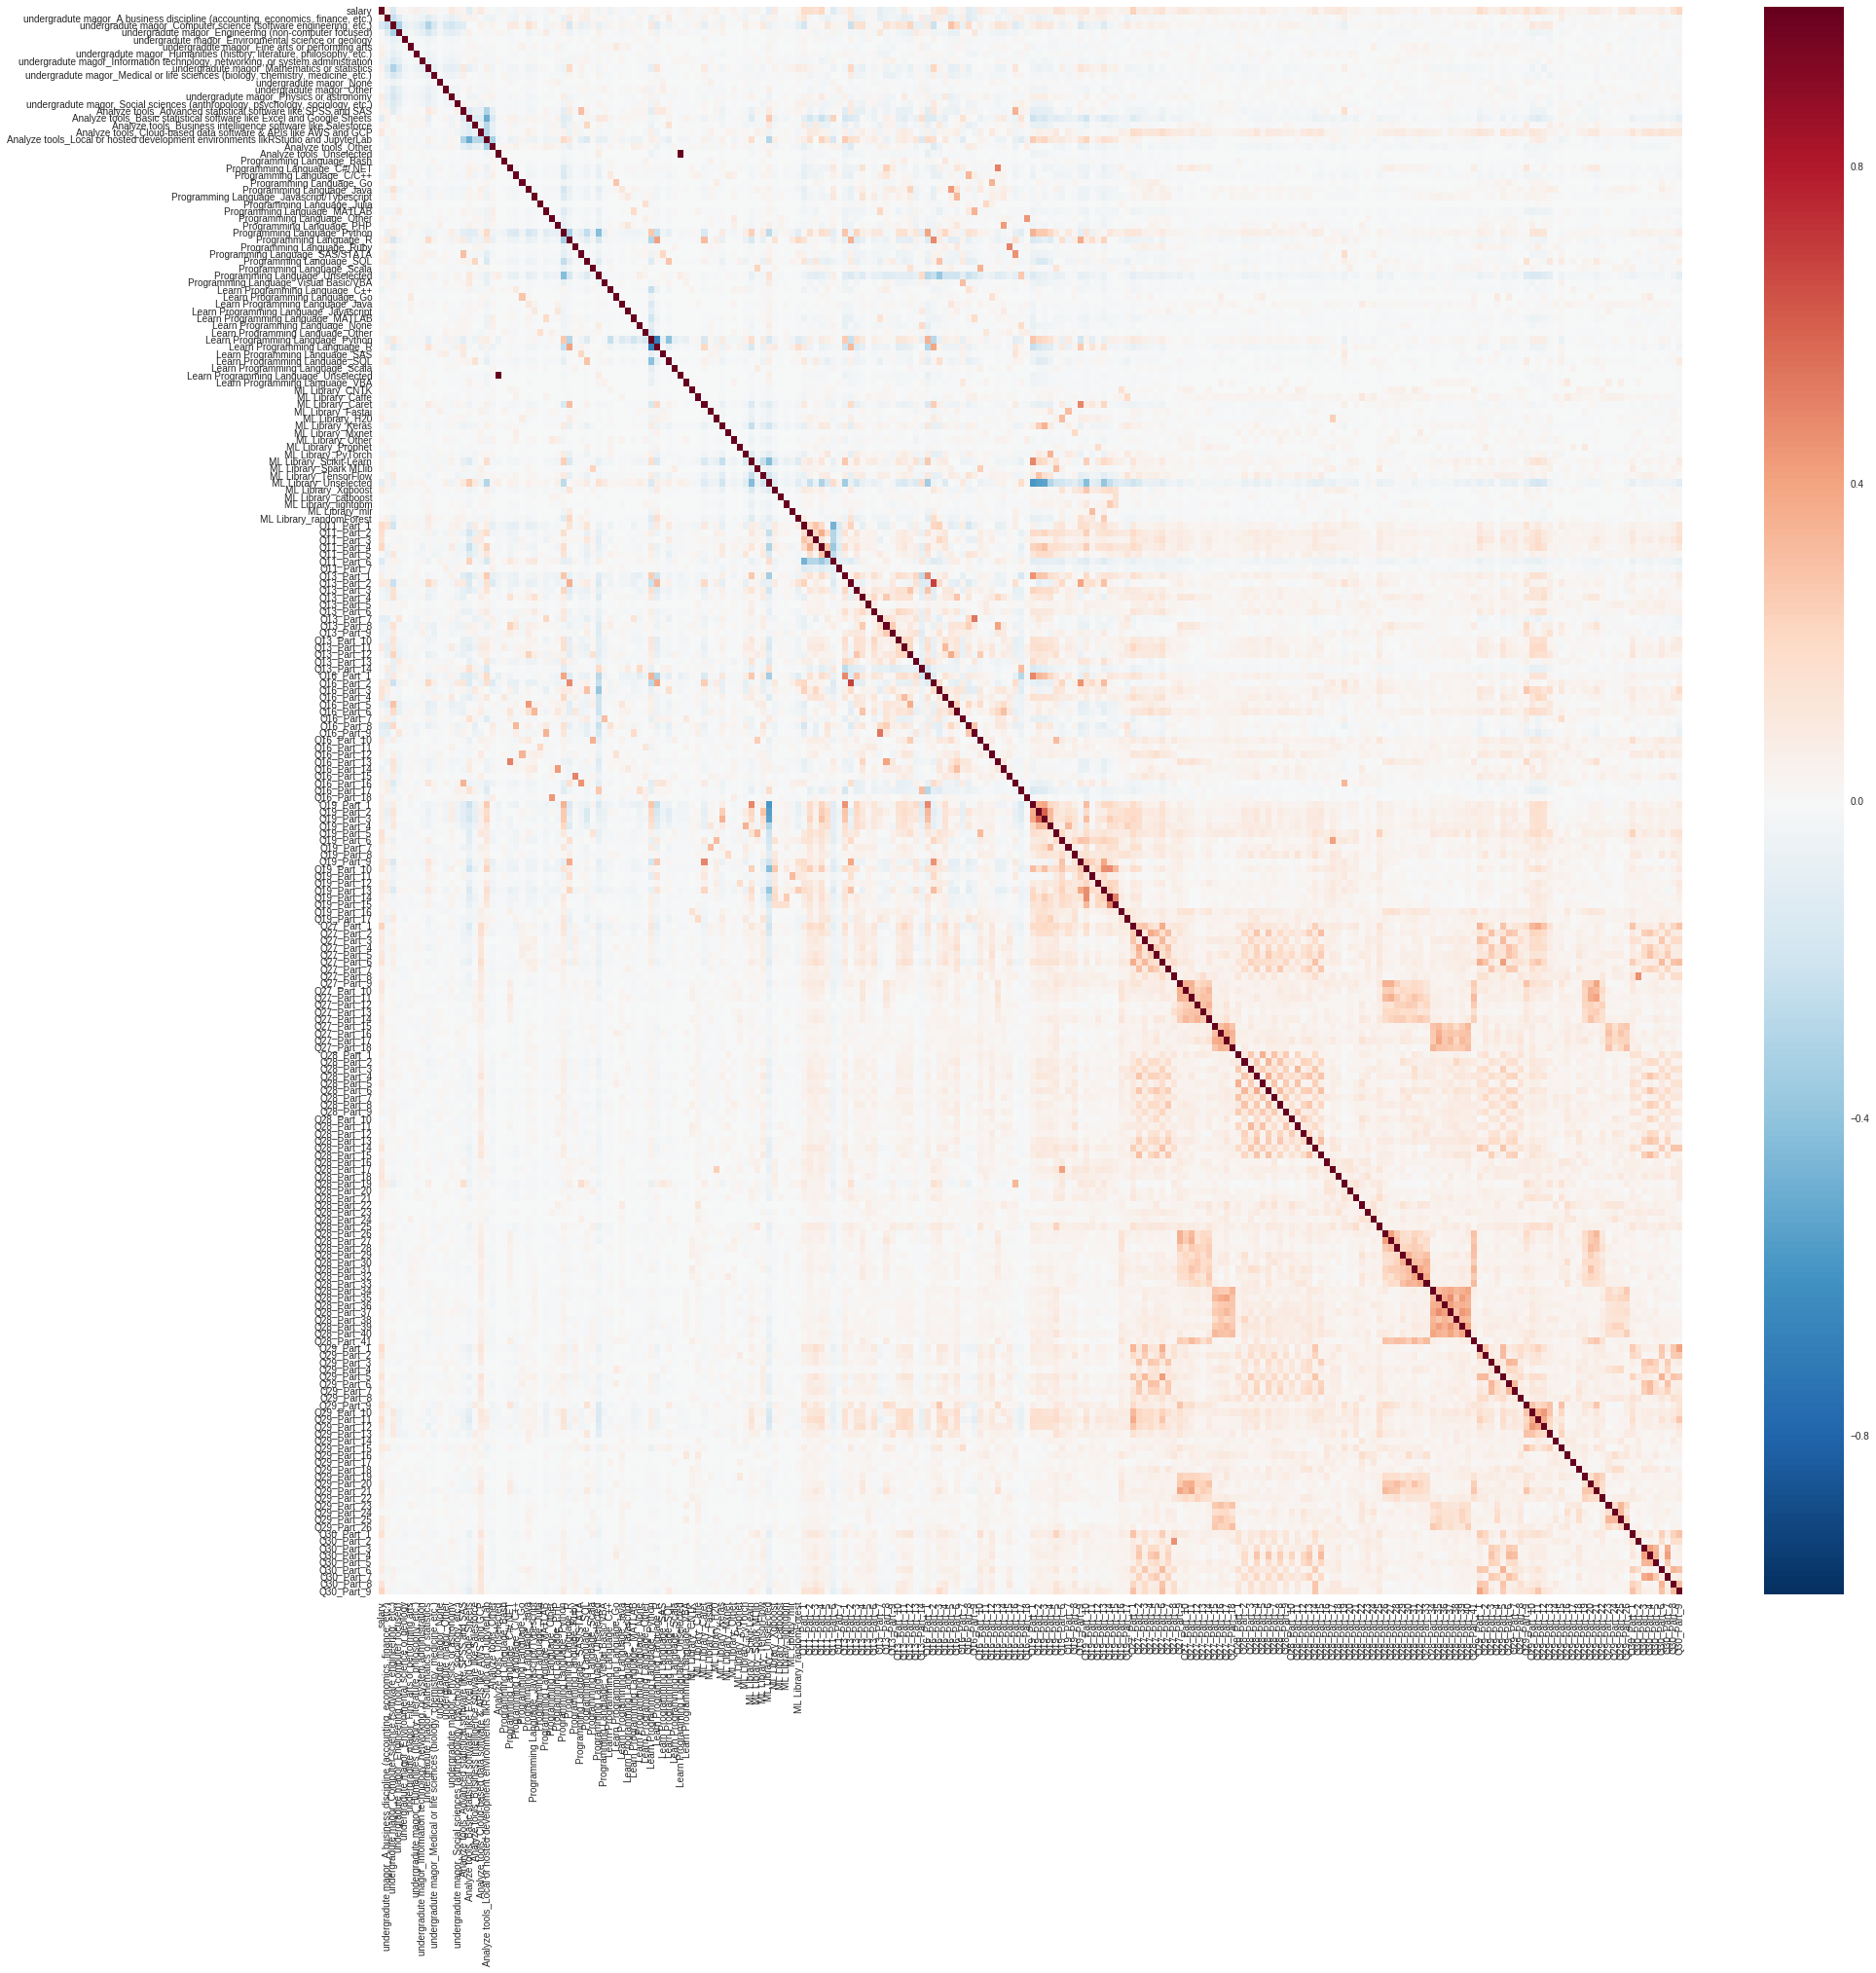

In [0]:
corr = total_salary.corr()
fig, ax = plt.subplots(figsize=(30,30)) 
sns.heatmap(corr, ax=ax)

In [0]:
corr

,salary,"undergradute magor_A business discipline (accounting, economics, finance, etc.)","undergradute magor_Computer science (software engineering, etc.)",undergradute magor_Engineering (non-computer focused),undergradute magor_Environmental science or geology,undergradute magor_Fine arts or performing arts,"undergradute magor_Humanities (history, literature, philosophy, etc.)","undergradute magor_Information technology, networking, or system administration",undergradute magor_Mathematics or statistics,"undergradute magor_Medical or life sciences (biology, chemistry, medicine, etc.)",...,Q29_Part_26,Q30_Part_1,Q30_Part_2,Q30_Part_3,Q30_Part_4,Q30_Part_5,Q30_Part_6,Q30_Part_7,Q30_Part_8,Q30_Part_9
salary,1.000000,0.064933,-0.154769,0.017035,0.002096,0.037514,0.065479,-0.046133,0.042403,0.017747,...,0.087212,0.150288,0.039712,0.050812,0.052663,0.047834,0.089823,0.035872,0.133590,0.217187
"undergradute magor_A business discipline (accounting, economics, finance, etc.)",0.064933,1.000000,-0.232388,-0.136288,-0.034742,-0.020111,-0.038150,-0.061369,-0.127612,-0.068271,...,0.010036,0.006337,0.003559,-0.005781,-0.009701,0.014945,-0.024154,-0.022642,-0.013825,0.028438
"undergradute magor_Computer science (software engineering, etc.)",-0.154769,-0.232388,1.000000,-0.327934,-0.083597,-0.048390,-0.091795,-0.147664,-0.307058,-0.164273,...,-0.006512,0.020724,-0.009009,0.008889,0.016180,-0.001488,0.049884,0.038485,0.015409,-0.028984
undergradute magor_Engineering (non-computer focused),0.017035,-0.136288,-0.327934,1.000000,-0.049027,-0.028379,-0.053835,-0.086600,-0.180080,-0.096341,...,0.020448,0.007189,-0.015045,-0.008113,-0.014627,-0.010281,-0.021954,-0.003325,-0.011859,-0.011988
undergradute magor_Environmental science or geology,0.002096,-0.034742,-0.083597,-0.049027,1.000000,-0.007234,-0.013724,-0.022076,-0.045906,-0.024559,...,-0.013802,-0.023755,-0.012326,-0.013083,0.012390,-0.012239,0.013062,-0.000782,-0.018273,-0.018160
undergradute magor_Fine arts or performing arts,0.037514,-0.020111,-0.048390,-0.028379,-0.007234,1.000000,-0.007944,-0.012779,-0.026572,-0.014216,...,-0.007989,-0.013751,-0.007135,0.014847,0.006942,-0.007084,-0.009933,-0.007807,-0.010577,0.013405
"undergradute magor_Humanities (history, literature, philosophy, etc.)",0.065479,-0.038150,-0.091795,-0.053835,-0.013724,-0.007944,1.000000,-0.024241,-0.050408,-0.026968,...,-0.015155,-0.012517,-0.000872,0.009528,-0.000980,0.024811,-0.000448,-0.003210,-0.002737,0.038150
"undergradute magor_Information technology, networking, or system administration",-0.046133,-0.061369,-0.147664,-0.086600,-0.022076,-0.012779,-0.024241,1.000000,-0.081087,-0.043381,...,-0.002727,0.018473,0.002399,-0.000304,-0.024987,0.002720,0.004803,-0.009061,-0.010226,-0.018405
undergradute magor_Mathematics or statistics,0.042403,-0.127612,-0.307058,-0.180080,-0.045906,-0.026572,-0.050408,-0.081087,1.000000,-0.090208,...,-0.019464,-0.007869,0.011380,-0.011050,0.017204,-0.014237,-0.012382,-0.025585,0.013392,0.002406
"undergradute magor_Medical or life sciences (biology, chemistry, medicine, etc.)",0.017747,-0.068271,-0.164273,-0.096341,-0.024559,-0.014216,-0.026968,-0.043381,-0.090208,1.000000,...,0.005607,-0.031021,-0.009607,-0.018815,-0.008047,0.012738,-0.017798,-0.019809,-0.015909,-0.008662


# Importance

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_regression
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [0]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [0]:
salary_x = salary_x.values

In [0]:
salary_y = salary_y.values

In [0]:
salary_y.loc[salary_y['salary']<5000,'salary']=2500
salary_y.loc[(salary_y['salary']<10000) & (salary_y['salary']>=5000),'salary']=7500
salary_y.loc[(salary_y['salary']<20000) & (salary_y['salary']>=10000),'salary']=15000
salary_y.loc[(salary_y['salary']<30000) & (salary_y['salary']>=20000),'salary']=25000
salary_y.loc[(salary_y['salary']<40000) & (salary_y['salary']>=30000),'salary']=35000
salary_y.loc[(salary_y['salary']<50000) & (salary_y['salary']>=40000),'salary']=45000
salary_y.loc[(salary_y['salary']<60000) & (salary_y['salary']>=50000),'salary']=55000
salary_y.loc[(salary_y['salary']<70000) & (salary_y['salary']>=60000),'salary']=65000
salary_y.loc[(salary_y['salary']<80000) & (salary_y['salary']>=70000),'salary']=75000
salary_y.loc[(salary_y['salary']<10000) & (salary_y['salary']>=80000),'salary']=90000
salary_y.loc[(salary_y['salary']<200000) & (salary_y['salary']>=100000),'salary']=150000
salary_y.loc[(salary_y['salary']>=200000),'salary']=200000

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: 

In [0]:
model = LogisticRegression()
rfe = RFE(model)
fit = rfe.fit(salary_x,salary_y)
print(rfe.support_)
print(rfe.ranking_)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Defaul

[ True  True  True  True False False  True  True  True False  True  True
  True  True  True  True  True  True  True False False False False False
 False False False False False False  True  True False False  True False
  True False False False False False False False False  True  True False
  True False False False False False  True False False  True False False
 False False  True False  True  True  True False False False  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False False  True  True False  True
  True  True  True  True  True  True  True  True  True False  True  True
  True  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True False False False False False False False False
 False False False  True False False  True False False False False False
 False False  True False False  True False  True Fa

In [0]:
print(model.feature_importances_)

AttributeError: ignored

# * Machine Learning

# Feature selection

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, auc, mean_absolute_error
from sklearn.feature_selection import RFE

In [0]:
models = {
    'lr': LinearRegression(),
    'la': Lasso(),
    'gb': GradientBoostingRegressor(n_estimators=100),
}

In [0]:
model_lr=LinearRegression()
rfe = RFE(model_lr)
fit = rfe.fit(salary_x,salary_y)

C:\Users\Kimi\Anaconda3\envs\tensoeflow\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
sorted(list(zip(fit.ranking_,salary_x)))

[(1, 'Analyze tools_Basic statistical software like Excel and Google Sheets'),
 (1,
  'Analyze tools_Local or hosted development environments likRStudio and JupyterLab'),
 (1, 'Analyze tools_Unselected'),
 (1, 'Education level_Bachelors degree'),
 (1, 'Education level_Doctoral degree'),
 (1, 'Education level_Masters degree'),
 (1, 'Education level_None'),
 (1, 'Education level_Professional degree'),
 (1, 'Job_titles_Business Analyst'),
 (1, 'Job_titles_Chief Officer'),
 (1, 'Job_titles_Consultant'),
 (1, 'Job_titles_DBA/Database Engineer'),
 (1, 'Job_titles_Data Analyst'),
 (1, 'Job_titles_Data Engineer'),
 (1, 'Job_titles_Data Journalist'),
 (1, 'Job_titles_Data Scientist'),
 (1, 'Job_titles_Developer Advocate'),
 (1, 'Job_titles_Manager'),
 (1, 'Job_titles_Marketing Analyst'),
 (1, 'Job_titles_Other'),
 (1, 'Job_titles_Principal Investigator'),
 (1, 'Job_titles_Product/Project Manager'),
 (1, 'Job_titles_Research Assistant'),
 (1, 'Job_titles_Research Scientist'),
 (1, 'Job_titles_Sa

In [0]:
ranks=fit.ranking_
feature_indexes=[]
for i in range(len(ranks)):
    if ranks[i]==1:
        feature_indexes+=[i]
# print(feature_indexes)
salary_x_new=salary_x.iloc[:,feature_indexes]

# ML

In [0]:
resultDF = pd.DataFrame(columns=['model','mean_Acc_train','Std_train','mean_Acc_test','Std_test'])
df_idx = 0

In [0]:
def run_kfold(model,X,Y):
    
    global df_idx
    
#     X = salary_x_new
#     Y = salary_Y
     
    outcomes_train = []
    outcomes_err_train= []
    outcomes_test = []
    outcomes_err_test= []
    
    fold = 0 
    kf = KFold(n_splits=10)
    
    for train_index, test_index in kf.split(X):
        fold += 1
        X_train, X_test = X.values[train_index], X.values[test_index]
        Y_train, Y_test = Y.values[train_index], Y.values[test_index]
        
        model.fit(X_train, Y_train)
        Y_pre_train = model.predict(X_train)
        Y_pre_test = model.predict(X_test)
        
        accuracy_train = r2_score(Y_train, Y_pre_train)
        accuracy_test = r2_score(Y_test, Y_pre_test)
        
        trainErr_train = mean_squared_error(Y_train, Y_pre_train)
        trainErr_test = mean_squared_error(Y_test, Y_pre_test)
        
        outcomes_train.append(accuracy_train)
        outcomes_err_train.append(trainErr_train)
        outcomes_test.append(accuracy_test)
        outcomes_err_test.append(trainErr_test)
        
        print("Fold {0} train accuracy: {1}".format(fold, accuracy_train))   
        print("Fold {0} test accuracy: {1}".format(fold, accuracy_test))
        
    mean_outcome_train = np.mean(outcomes_train)
    mean_error_train = np.mean(trainErr_train)
    std_outcome_train = np.std(outcomes_train)
    
    mean_outcome_test = np.mean(outcomes_test)
    mean_error_test = np.mean(trainErr_test)
    std_outcome_test = np.std(outcomes_test)
    
    resultDF.loc[df_idx, 'model'] = name
    resultDF.loc[df_idx, 'mean_Acc_train'] = np.mean(outcomes_train)
    resultDF.loc[df_idx, 'Std_train'] = np.std(outcomes_train)
    resultDF.loc[df_idx, 'mean_Acc_test'] = np.mean(outcomes_test)
    resultDF.loc[df_idx, 'Std_test'] = np.std(outcomes_test)
    
    df_idx += 1 
    
    print("Mean accurancy for train data: {0}".format(mean_outcome_train)) 
    print("Standard Deviation for train data: {0}".format(std_outcome_train))
    print("Mean accurancy for test data: {0}".format(mean_outcome_test)) 
    print("Standard Deviation for test data: {0}".format(std_outcome_test))
    
    return mean_outcome_test, std_outcome_test

In [0]:
for name, model in models.items():
    print ("Fitting " + name + " model")
    run_kfold(model,salary_x,salary_y)

Fitting lr model
Fold 1 train accuracy: 0.26258962400040753
Fold 1 test accuracy: -0.05575219865405101
Fold 2 train accuracy: 0.24912549934602934
Fold 2 test accuracy: 0.2438674048304904
Fold 3 train accuracy: 0.24737443759877675
Fold 3 test accuracy: 0.2961029815892803
Fold 4 train accuracy: 0.2555648038644982
Fold 4 test accuracy: 0.24755348933224186
Fold 5 train accuracy: 0.2639969055671224
Fold 5 test accuracy: 0.1640749058800801
Fold 6 train accuracy: 0.25652163753690216
Fold 6 test accuracy: 0.22635458724573898
Fold 7 train accuracy: 0.25632572843770174
Fold 7 test accuracy: 0.239290965900406
Fold 8 train accuracy: 0.2687705220203348
Fold 8 test accuracy: 0.1508916310412466
Fold 9 train accuracy: 0.260363257116593
Fold 9 test accuracy: 0.20011873195396002
Fold 10 train accuracy: 0.26859732899161426
Fold 10 test accuracy: 0.022028026609391627
Mean accurancy for train data: 0.25892297444799806
Standard Deviation for train data: 0.006964046785671931
Mean accurancy for test data: 0.1

C:\Users\Kimi\Anaconda3\envs\tensoeflow\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Fold 3 train accuracy: 0.24738139900136746
Fold 3 test accuracy: 0.29666777100397335
Fold 4 train accuracy: 0.25555859150368887
Fold 4 test accuracy: 0.24783020477827433


C:\Users\Kimi\Anaconda3\envs\tensoeflow\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Fold 5 train accuracy: 0.2639943037962076
Fold 5 test accuracy: 0.16482025623798557


C:\Users\Kimi\Anaconda3\envs\tensoeflow\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Fold 6 train accuracy: 0.25658527999561775
Fold 6 test accuracy: 0.22692916991157053


C:\Users\Kimi\Anaconda3\envs\tensoeflow\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Fold 7 train accuracy: 0.25632993783063873
Fold 7 test accuracy: 0.23970747136721227
Fold 8 train accuracy: 0.2688597765641326
Fold 8 test accuracy: 0.15204250323141433
Fold 9 train accuracy: 0.2604732502624405
Fold 9 test accuracy: 0.20055760803410183


C:\Users\Kimi\Anaconda3\envs\tensoeflow\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Fold 10 train accuracy: 0.2686170197040374
Fold 10 test accuracy: 0.023092808364635897
Mean accurancy for train data: 0.2589583239730288
Standard Deviation for train data: 0.0069755775471760945
Mean accurancy for test data: 0.17430750672328643
Standard Deviation for test data: 0.10432320305936892
Fitting gb model


C:\Users\Kimi\Anaconda3\envs\tensoeflow\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 1 train accuracy: 0.30856296956267426
Fold 1 test accuracy: -0.12247767212181038


C:\Users\Kimi\Anaconda3\envs\tensoeflow\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 2 train accuracy: 0.29856022165540064
Fold 2 test accuracy: 0.2379682726891159


C:\Users\Kimi\Anaconda3\envs\tensoeflow\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 3 train accuracy: 0.2948610231028469
Fold 3 test accuracy: 0.28454371645174126


C:\Users\Kimi\Anaconda3\envs\tensoeflow\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 4 train accuracy: 0.30406954975690836
Fold 4 test accuracy: 0.22786854280796998


C:\Users\Kimi\Anaconda3\envs\tensoeflow\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 5 train accuracy: 0.30473295300447356
Fold 5 test accuracy: 0.1598421389331216


C:\Users\Kimi\Anaconda3\envs\tensoeflow\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 6 train accuracy: 0.29967159953239764
Fold 6 test accuracy: 0.21638368768600158


C:\Users\Kimi\Anaconda3\envs\tensoeflow\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 7 train accuracy: 0.3022859747111615
Fold 7 test accuracy: 0.23673364127080443


C:\Users\Kimi\Anaconda3\envs\tensoeflow\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 8 train accuracy: 0.31167844282783075
Fold 8 test accuracy: 0.1351572739637923


C:\Users\Kimi\Anaconda3\envs\tensoeflow\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 9 train accuracy: 0.3050451483707114
Fold 9 test accuracy: 0.18933654919535547


C:\Users\Kimi\Anaconda3\envs\tensoeflow\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 10 train accuracy: 0.31134426144020244
Fold 10 test accuracy: 0.03630442399871636
Mean accurancy for train data: 0.30408121439646074
Standard Deviation for train data: 0.005196833715507155
Mean accurancy for test data: 0.16016605748748086
Standard Deviation for test data: 0.11481954275768357


In [0]:
def run_kfold_nn(model,X,Y):
    
    global df_idx
    
#     X = salary_x_new
#     Y = salary_Y
     
    outcomes_train = []
    outcomes_err_train= []
    outcomes_test = []
    outcomes_err_test= []
    
    fold = 0 
    kf = KFold(n_splits=10)
    
    for train_index, test_index in kf.split(X):
        fold += 1
        X_train, X_test = X.values[train_index], X.values[test_index]
        Y_train, Y_test = Y.values[train_index], Y.values[test_index]
        
        model.fit(X_train, Y_train)
        Y_pre_train = model.predict(X_train)
        Y_pre_test = model.predict(X_test)
        
        accuracy_train = r2_score(Y_train, Y_pre_train)
        accuracy_test = r2_score(Y_test, Y_pre_test)
        
        trainErr_train = mean_squared_error(Y_train, Y_pre_train)
        trainErr_test = mean_squared_error(Y_test, Y_pre_test)
        
        outcomes_train.append(accuracy_train)
        outcomes_err_train.append(trainErr_train)
        outcomes_test.append(accuracy_test)
        outcomes_err_test.append(trainErr_test)
        
        print("Fold {0} train accuracy: {1}".format(fold, accuracy_train))   
        print("Fold {0} test accuracy: {1}".format(fold, accuracy_test))
        
    mean_outcome_train = np.mean(outcomes_train)
    mean_error_train = np.mean(trainErr_train)
    std_outcome_train = np.std(outcomes_train)
    
    mean_outcome_test = np.mean(outcomes_test)
    mean_error_test = np.mean(trainErr_test)
    std_outcome_test = np.std(outcomes_test)

    df_idx += 1 
    
    print("Mean accurancy for train data: {0}".format(mean_outcome_train)) 
    print("Standard Deviation for train data: {0}".format(std_outcome_train))
    print("Mean accurancy for test data: {0}".format(mean_outcome_test)) 
    print("Standard Deviation for test data: {0}".format(std_outcome_test))
    
    return mean_outcome_test, std_outcome_test

In [0]:
leanrning_rate_list = [0.001,0.01,0.1,0.5]
hidden_layer_sizes_list = [(50,30,10),(30,10,5),(10,8,4)]
max_iter_list = [1000,500,300]

In [0]:
def neural_network(X,Y,leanrning_rate_list,hidden_layer_sizes_list,max_iter_list):
    
    for index1 in leanrning_rate_list:
        print('learning rate = ')
        print(index1)
        mlp_alpha = MLPRegressor(solver='adam',random_state=42,learning_rate_init=index1)
        run_kfold(mlp_alpha,X,Y)
    print('----------------------------------')
    
    for index2 in hidden_layer_sizes_list:
        print('The number and size of hidden layers = ')
        print(index2)
        mlp_hidden = MLPRegressor(solver='adam',random_state=42,hidden_layer_sizes=index2)
        run_kfold(mlp_hidden,X,Y)
    print('----------------------------------')
        
    for index3 in max_iter_list:
        print('The number of max iterations = ')
        print(index3)
        mlp_iter = MLPRegressor(solver='adam',random_state=42,max_iter=index3)
        run_kfold(mlp_iter,X,Y)
    print('----------------------------------')


In [0]:
neural_network(salary_x,salary_y,leanrning_rate_list,hidden_layer_sizes_list,max_iter_list)

learning rate = 
0.001


C:\Users\Kimi\Anaconda3\envs\tensoeflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Kimi\Anaconda3\envs\tensoeflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Fold 1 train accuracy: 0.0968190036858777
Fold 1 test accuracy: -0.10086129094158558
Fold 2 train accuracy: 0.09604854914171368
Fold 2 test accuracy: 0.05789223980706948
Fold 3 train accuracy: 0.09627705246045615
Fold 3 test accuracy: 0.08600146379721685
Fold 4 train accuracy: 0.09676425972012093
Fold 4 test accuracy: 0.10499232286398241
Fold 5 train accuracy: 0.1031196754738204
Fold 5 test accuracy: 0.08490360020400012
Fold 6 train accuracy: 0.09963150745239124
Fold 6 test accuracy: 0.08458881579417088
Fold 7 train accuracy: 0.0999303485215014
Fold 7 test accuracy: 0.09870508851676052
Fold 8 train accuracy: 0.10689802786556346
Fold 8 test accuracy: 0.040840322267448936
Fold 9 train accuracy: 0.10068328156829975
Fold 9 test accuracy: 0.0808965949783097
Fold 10 train accuracy: 0.10377606897321412
Fold 10 test accuracy: -0.010045795903934174
Mean accurancy for train data: 0.09999477748629589
Standard Deviation for train data: 0.0034963431525615474
Mean accurancy for test data: 0.05279133

C:\Users\Kimi\Anaconda3\envs\tensoeflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Fold 8 train accuracy: 0.19899540490648993
Fold 8 test accuracy: 0.1396039895517841
Fold 9 train accuracy: 0.1545752574838123
Fold 9 test accuracy: 0.12664947345797106
Fold 10 train accuracy: -0.6959559438248026
Fold 10 test accuracy: -0.400663315634054
Mean accurancy for train data: 0.10332275039968646
Standard Deviation for train data: 0.26674626884746155
Mean accurancy for test data: 0.08575334287495898
Standard Deviation for test data: 0.17748826598646908
The number and size of hidden layers = 
(30, 10, 5)
Fold 1 train accuracy: -0.6825555651759341
Fold 1 test accuracy: -0.5648744580154288
Fold 2 train accuracy: -0.6302024183379211
Fold 2 test accuracy: -1.002945479795756
Fold 3 train accuracy: 0.12585250308550722
Fold 3 test accuracy: 0.13290938760644433
Fold 4 train accuracy: -0.6568221507941061
Fold 4 test accuracy: -0.7212230419217811
Fold 5 train accuracy: -0.6612454553933087
Fold 5 test accuracy: -0.6581425202366515
Fold 6 train accuracy: -0.6419435935431381
Fold 6 test accur